In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import operator

from torch import nn
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from pprint import pprint
from itertools import chain
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import entropy
from tqdm.auto import tqdm

#### Defining a Deep Neural Network (DNN)

* Since the same DNN backbone to be created for the many experiments in this assignment, it felt right to create a `NeuralNetwork` class that is parameterized by various design schemas that may be needed, enabling reuse. 

* The class `NeuralNetwork` takes the following parameters:

    > `n_layers`: The number of hidden layers

    > `n_units`: The number of units in each hidden layer (except the input and output layers)

    > `activation`: The activation to use between the hidden layers

    > `layer_init`: The initialization scheme for the layers

    > `dropout`: The dropout scheme between the layers (specified as a Python list)

* Calling the class returns a fresh DNN (Deep Neural Network) object which can be trained by calling the `.train()` method on itself

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_layers, n_units, activation, layer_init=None, dropout=False):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden_layer_stack = self.create_hidden_layer_stack(n_layers, n_units, activation, dropout)
        self.loss_fn = nn.NLLLoss()
        if layer_init:
            self.apply(lambda layer: self.weights_init(layer=layer, layer_init=layer_init))

    def create_hidden_layer_stack(self, n_layers, n_units, activation, dropout):
        if not dropout:
            dropout = [0.0] * n_layers
        hidden_layers = [(nn.Dropout(p=dropout[i]),
                          nn.Linear(in_features=n_units if i!=0 else 784, 
                                    out_features=n_units if i!=(n_layers-1) else 10), 
                          getattr(nn, activation)() if i!=(n_layers-1) else nn.LogSoftmax(dim=1)) 
                         for i in range(n_layers)]
        hidden_layer_stack = nn.Sequential(*chain.from_iterable(hidden_layers))
        return hidden_layer_stack
    
    def weights_init(self, layer, layer_init):
        if isinstance(layer, nn.Linear):
            if layer_init == 'normal_':
                getattr(nn.init, layer_init)(layer.weight.data, mean=0.0, std=0.01)
                getattr(nn.init, layer_init)(layer.bias.data, mean=0.0, std=0.01)
            else:
                getattr(nn.init, layer_init)(layer.weight.data)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.hidden_layer_stack(x)
        return logits
        
    def train_loop(self, train_dataloader, optimizer):
        batch_losses = list()
        batch_accs = list()
        num_batches = len(train_dataloader)
        for batch, (inputs, targets) in enumerate(train_dataloader):
            # compute prediction and loss
            logits = self(inputs.to(device))
            loss = self.loss_fn(logits, targets.to(device))

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # record batch loss
            batch_losses.append(loss.item())
            
            # record batch accuracy
            predictions = torch.argmax(logits, dim=1)
            batch_acc = torch.sum(predictions == targets.to(device)) / len(inputs)
            batch_accs.append(batch_acc.item())
        
        # collect metrics (epoch)
        train_loss = sum(batch_losses) / num_batches
        train_accuracy = sum(batch_accs) / num_batches
        
        return (train_loss, train_accuracy)
        
    def test_loop(self, test_dataloader, return_logits=False):
        batch_losses = list()
        batch_accs = list()
        batch_logits = list()
        batch_labels = list()
        num_batches = len(test_dataloader)
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                logits = self(inputs.to(device))
                loss = self.loss_fn(logits, targets.to(device))
                
                # record logits and targets
                batch_logits.append(logits.detach())
                batch_labels.append(targets.detach())
                
                # record batch loss
                batch_losses.append(loss.item())
                
                # record batch accuracy
                predictions = torch.argmax(logits, dim=1)
                batch_acc = torch.sum(predictions == targets.to(device)) / len(inputs)
                batch_accs.append(batch_acc.item())
        
        # collect metrics 
        test_loss = sum(batch_losses) / num_batches
        test_accuracy = sum(batch_accs) / num_batches
        logits = torch.cat(batch_logits)
        labels = torch.cat(batch_labels)
        
        if return_logits:
            return (test_loss, test_accuracy, logits, labels)
        else:
            return (test_loss, test_accuracy)
    
    def train_model(self, epochs, train_dataloader, optimizer, test_dataloader=None, stopping_criteria=None, return_metrics=False):
        # set the model in train mode
        self.train(mode=True)
        train_metrics = defaultdict(list)
        test_metrics = defaultdict(list)
        pbar = tqdm(range(epochs))
        for epoch in (pbar):
            (train_loss, train_accuracy) = self.train_loop(train_dataloader, optimizer)
            train_metrics['Loss'].append(train_loss)
            train_metrics['Accuracy'].append(train_accuracy)
            
            # optionally log test
            if test_dataloader:
                (test_loss, test_accuracy) = self.test_loop(test_dataloader)
                test_metrics['Loss'].append(test_loss)
                test_metrics['Accuracy'].append(test_accuracy)
                pbar.set_description(f'Test Loss: {test_loss:.2f}, Test Accuracy: {(test_accuracy * 100):.2f}%')
            else:
                # log train metrics
                pbar.set_description(f'Train Loss: {train_loss:.2f}, Train Accuracy: {(train_accuracy * 100):.2f}%')
            
            # check for stopping condition
            if stopping_criteria and test_metrics:
                if test_accuracy >= stopping_criteria:
                    print("Stopping training because stopping criteria reached.")
                    break
            elif stopping_criteria and not test_metrics:
                raise ValueError('Stopping condition specified but test metrics are not available.')
            else:
                pass
        
        if return_metrics:
            return (train_metrics, test_metrics)
    
    def test_model(self, test_dataloader):
        self.train(mode=False)
        (test_loss, test_accuracy) = self.test_loop(test_dataloader)
        metrics = {'Loss': test_loss, 'Accuracy': test_accuracy}
        return metrics

In [17]:
def get_class_indices(logits, class_index):
    indices = torch.nonzero(logits.max(dim=1).indices == class_index).squeeze(dim=0)
    return indices

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

def register_hook(model, layer_name, sub_layer_idx):
    layer = getattr(model, layer_name)
    if sub_layer_idx != -1:
        handle = layer[sub_layer_idx].register_forward_hook(get_features(f'{layer_name}_{sub_layer_idx}'))
    else:
        handle = layer.register_forward_hook(get_features(f'{layer_name}_{sub_layer_idx}'))
    return handle

def select_dims(feature_map, condition='entropy', n_dims=10):
    if condition == 'entropy':
        entropy_dims = torch.tensor(entropy(feature_map.detach().cpu().numpy(), axis=0))
        non_zero_entropy_dims = entropy_dims[torch.nonzero(entropy_dims != 0)].squeeze()
        selected_dims = torch.topk(non_zero_entropy_dims, k=n_dims, dim=0, largest=False).indices
    elif condition == 'random':
        selected_dims = torch.tensor(random.sample(range(len(feature_map)), k=n_dims))
    else:
        raise ValueError('Please pass one of "entropy" or "random"')
    return selected_dims

def plot_scatter(input_arr, label_arr, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

    # plot
    scatter = ax.scatter(x=input_arr[:, 0], y=input_arr[:, 1], c=label_arr, cmap='tab10', alpha=0.5)
    ax.legend(*scatter.legend_elements(), loc="upper left", title="Class", title_fontsize=12, fontsize=12)
    ax.set_title(title, fontsize=18)

    # add mean for each class
    mean_labels = [class_idx for class_idx in range(len(label_arr.unique()))]
    means = np.stack([input_arr[torch.nonzero(label_arr==class_idx).squeeze()].mean(axis=0) 
                      for class_idx in mean_labels])
    scatter2 = ax.scatter(x=means[:, 0], y=means[:, 1], c=mean_labels, cmap='tab10', marker="x", s=20**2, alpha=1.0, linewidths=6.0)
    for i in range(len(label_arr.unique())):        
        ax.annotate(text=f'Class {i}', xy=means[i], ha='right' if i!=9 else 'left', va='bottom',size=12,
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.5))
    plt.show()

In [18]:
# detect device
def detect_device():
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

device = detect_device
print(f"Using {device} device")

Using mps device


#### Problem 1: A Detailed View to MNIST Classification [3 points]

This problem has been solved in four subsections as follows:

> Parts 1 - 2: Downloading the `MNIST` dataset from PyTorch servers

> Part 3: Training a model upto at least 98% accuracy on the test set and plotting samples from the last layer

> Part 4: Capturing output from the penultimate layer and plotting samples

> Parts 5 - 8: Plotting t-SNE and PCA visualizations from the output of each hidden layer

All relevant discussions and comments are noted in the markdown and code cells of the pertaining subsections. 

##### Downloading the `MNIST` dataset from PyTorch servers


In [19]:
# get train data
mnist_train = torchvision.datasets.MNIST("mnist",
                                         train=True,
                                         download=True,
                                         transform=torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.1307,), (0.3081,))]), 
                                         target_transform=torch.tensor)

# get test data
mnist_test = torchvision.datasets.MNIST("mnist",
                                        train=False,
                                        download=True,
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))]),
                                        target_transform=torchvision.torch.tensor)

##### Training a model upto at least 98% accuracy on the test set and plotting samples from the last layer

Here the last layer is `LogSoftmax` layer (`LogSoftmax` is preferred over `Softmax` since it is numerically more stable)

In [20]:
# initialize dataloaders
train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=2048)

In [21]:
# initialize model
model = NeuralNetwork(n_layers=5, n_units=1024, activation='ReLU').to(device)

In [22]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [23]:
# train model
train_metrics, test_metrics = model.train_model(epochs=20, 
                                                train_dataloader=train_dataloader, 
                                                test_dataloader=test_dataloader,
                                                optimizer=optimizer, 
                                                stopping_criteria=0.98, 
                                                return_metrics=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Stopping training because stopping criteria reached.


In [24]:
# sample 1000 test samples 
n_subset = 1000

# generate random indices 
subset_idx = random.sample(range(len(mnist_test)), k=n_subset)

# sample dataset
test_subset = Subset(mnist_test, subset_idx)

# create dataloader
test_subset_dataloader = DataLoader(test_subset, batch_size=n_subset)

# run inference
(test_loss, test_accuracy, logits, labels) = model.test_loop(test_subset_dataloader, return_logits=True)

In [25]:
# define the number of plots per class
n_sample_plot = 10

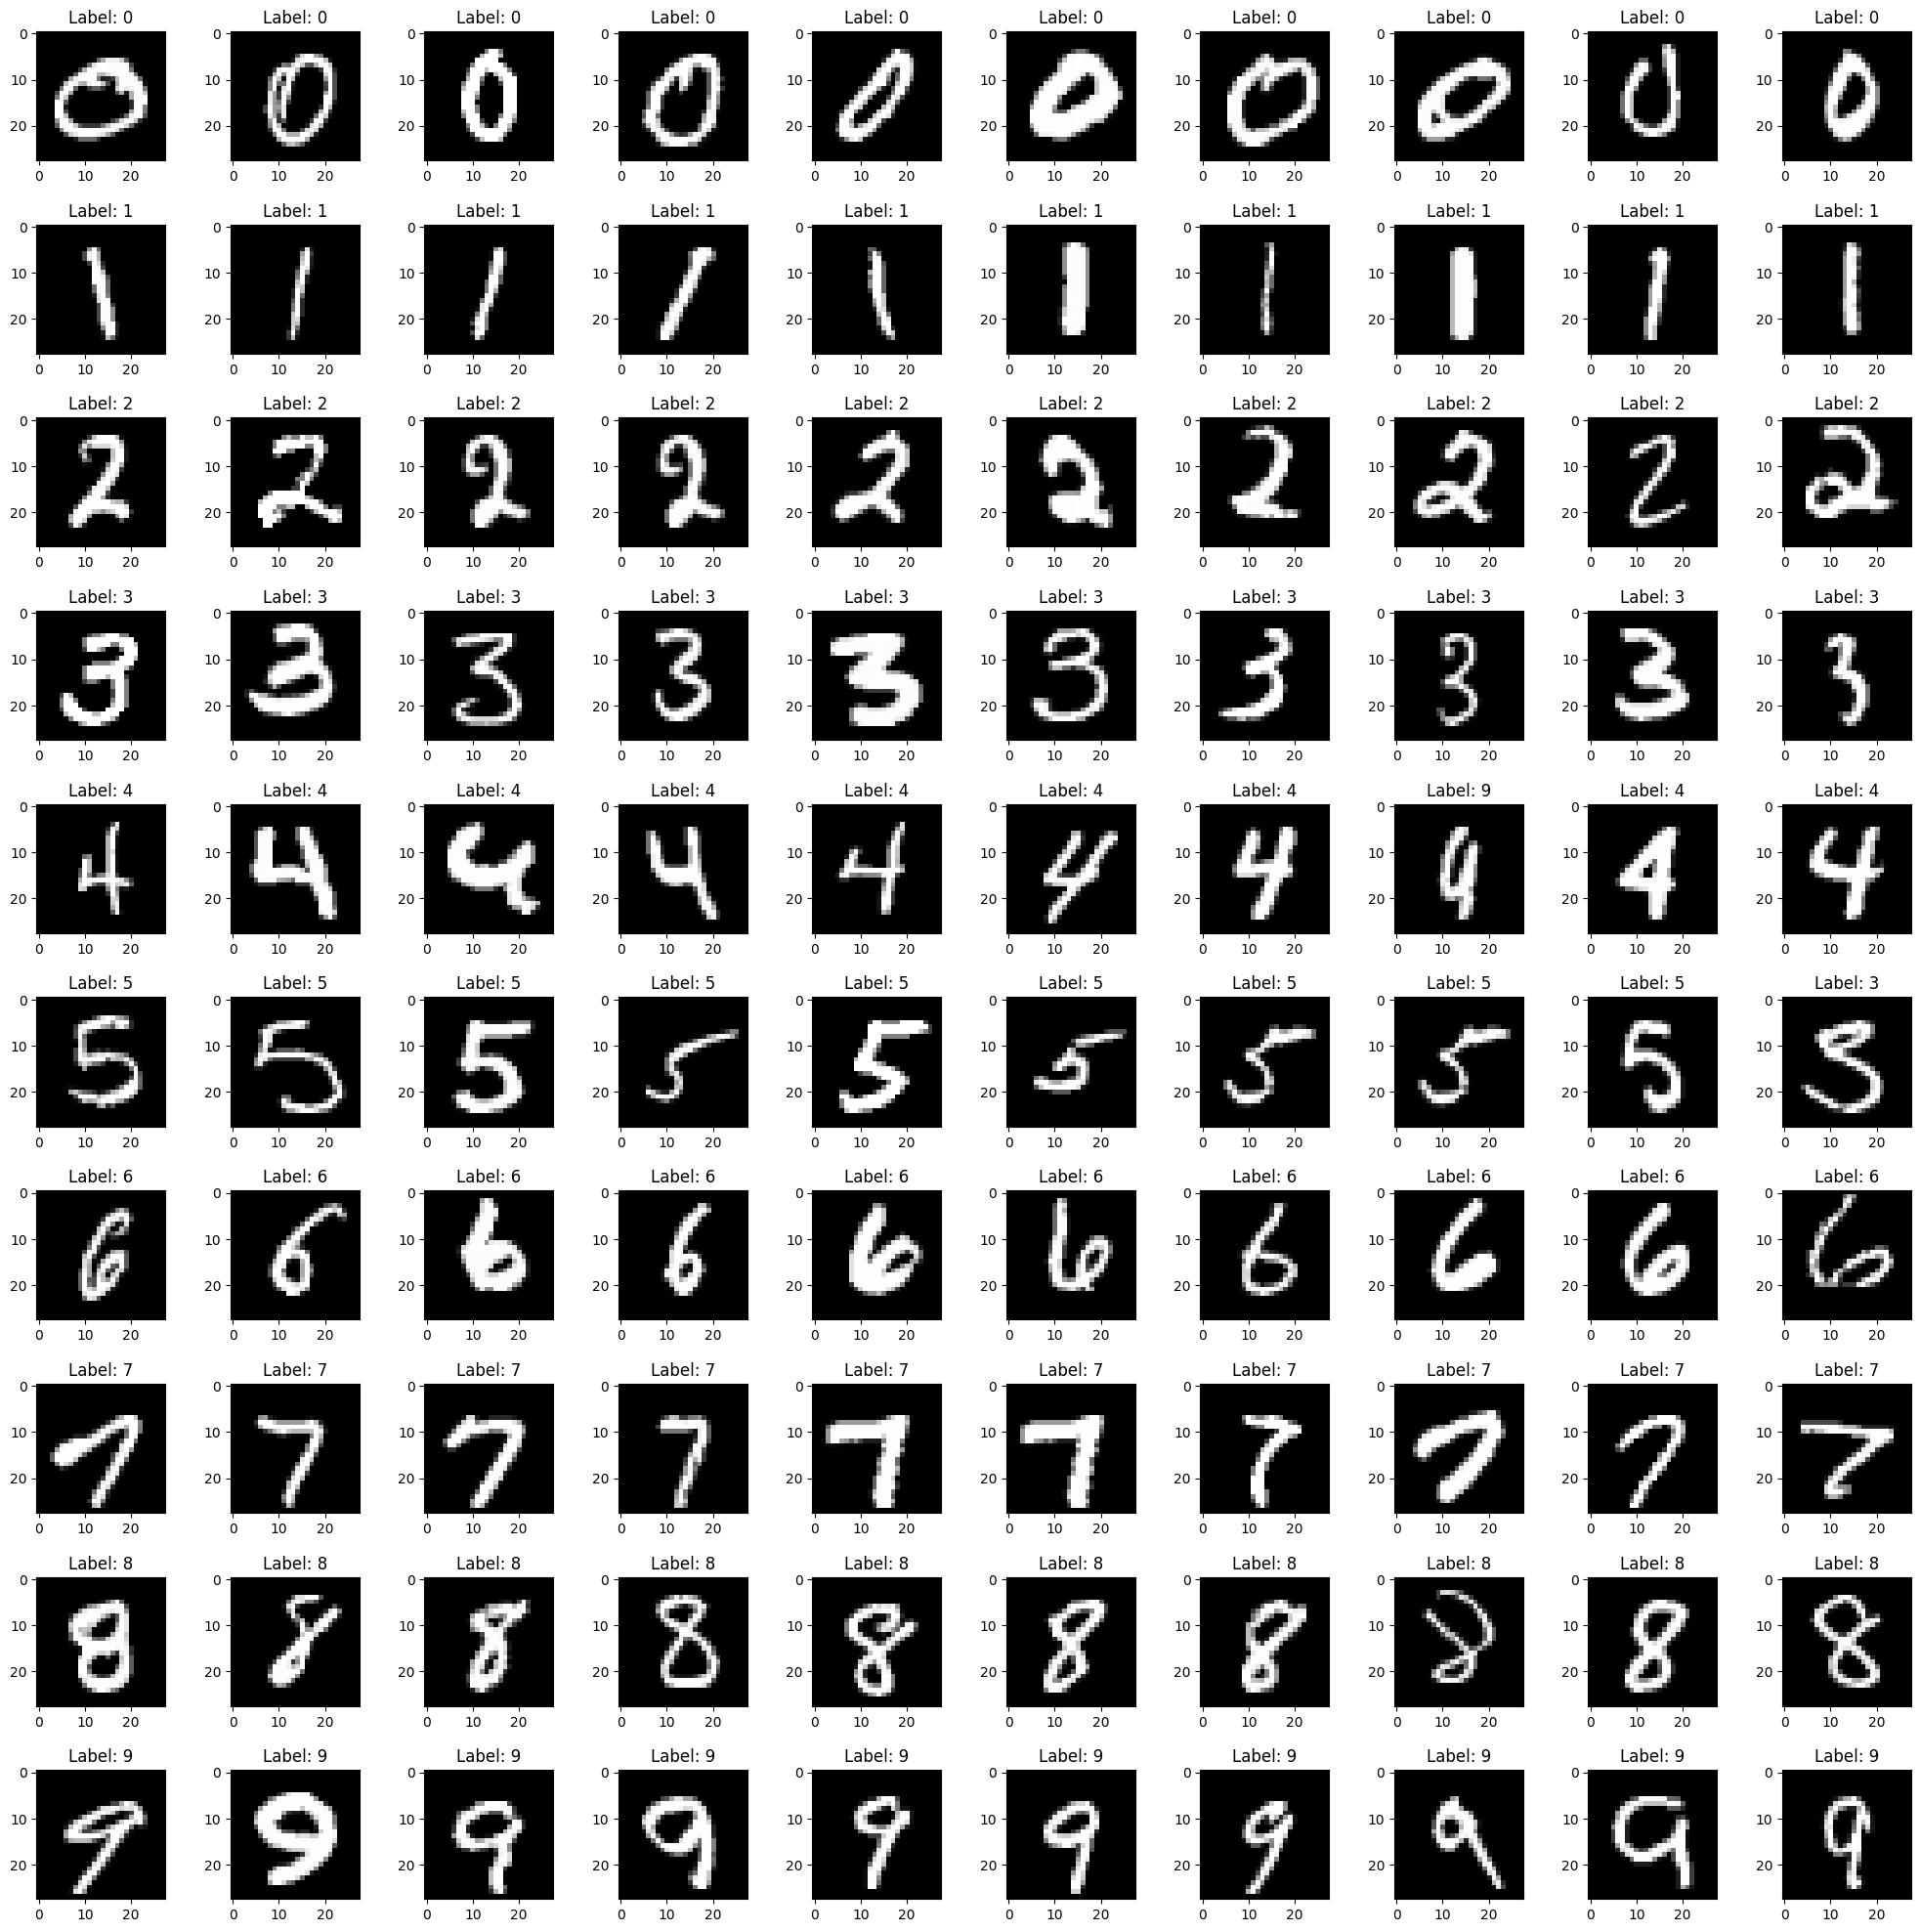

In [26]:
# plot
fig, ax = plt.subplots(nrows=n_sample_plot, ncols=n_sample_plot, figsize=(20, 20)) 
fig.tight_layout(h_pad=0.5)
for i in range(10):
    # select all for class i
    class_indices = get_class_indices(logits, class_index=i)
    
    # get random 10
    sampled_class_indices = class_indices[torch.randint(len(class_indices), (n_sample_plot,))]
    sampled_class_subset = Subset(test_subset, sampled_class_indices)
    
    # get images for those 10
    sampled_class_subset_images = list(map(operator.itemgetter(0), sampled_class_subset))
    
    # get labels for those 10
    sampled_class_subset_labels = list(map(operator.itemgetter(1), sampled_class_subset))    

    for j in range(10):
        ax[i, j].imshow(sampled_class_subset_images[j].squeeze().numpy(), cmap='gray')
        ax[i, j].set_title(f'Label: {sampled_class_subset_labels[j]}')

##### Capturing output from the penultimate layer and plotting samples

In [27]:
# create a handle to get the outputs of the penultimate layer
handle = register_hook(model, layer_name='hidden_layer_stack', sub_layer_idx=11)

In [28]:
# sample 1000 test samples 
n_subset = 1000

# generate random indices 
subset_idx = random.sample(range(len(mnist_test)), k=n_subset)

# sample dataset
test_subset = Subset(mnist_test, subset_idx)

# create dataloader
test_subset_dataloader = DataLoader(test_subset, batch_size=n_subset)

# run inference
features = {}
(test_loss, test_accuracy, logits, labels) = model.test_loop(test_subset_dataloader, return_logits=True)

# show metrics
print(f'Test Accuracy on subset: {test_accuracy * 100:.2f}%')

Test Accuracy on subset: 98.20%


In [29]:
# select 10 dimensions randomly
selected_dims = select_dims(feature_map=features['hidden_layer_stack_11'], 
                            condition='random', 
                            n_dims=10)

# get the sliced feature map according to the dimensions (neurons) chosen
sliced_feature_map = features['hidden_layer_stack_11'].index_select(dim=1, 
                                                                    index=selected_dims.to(device))

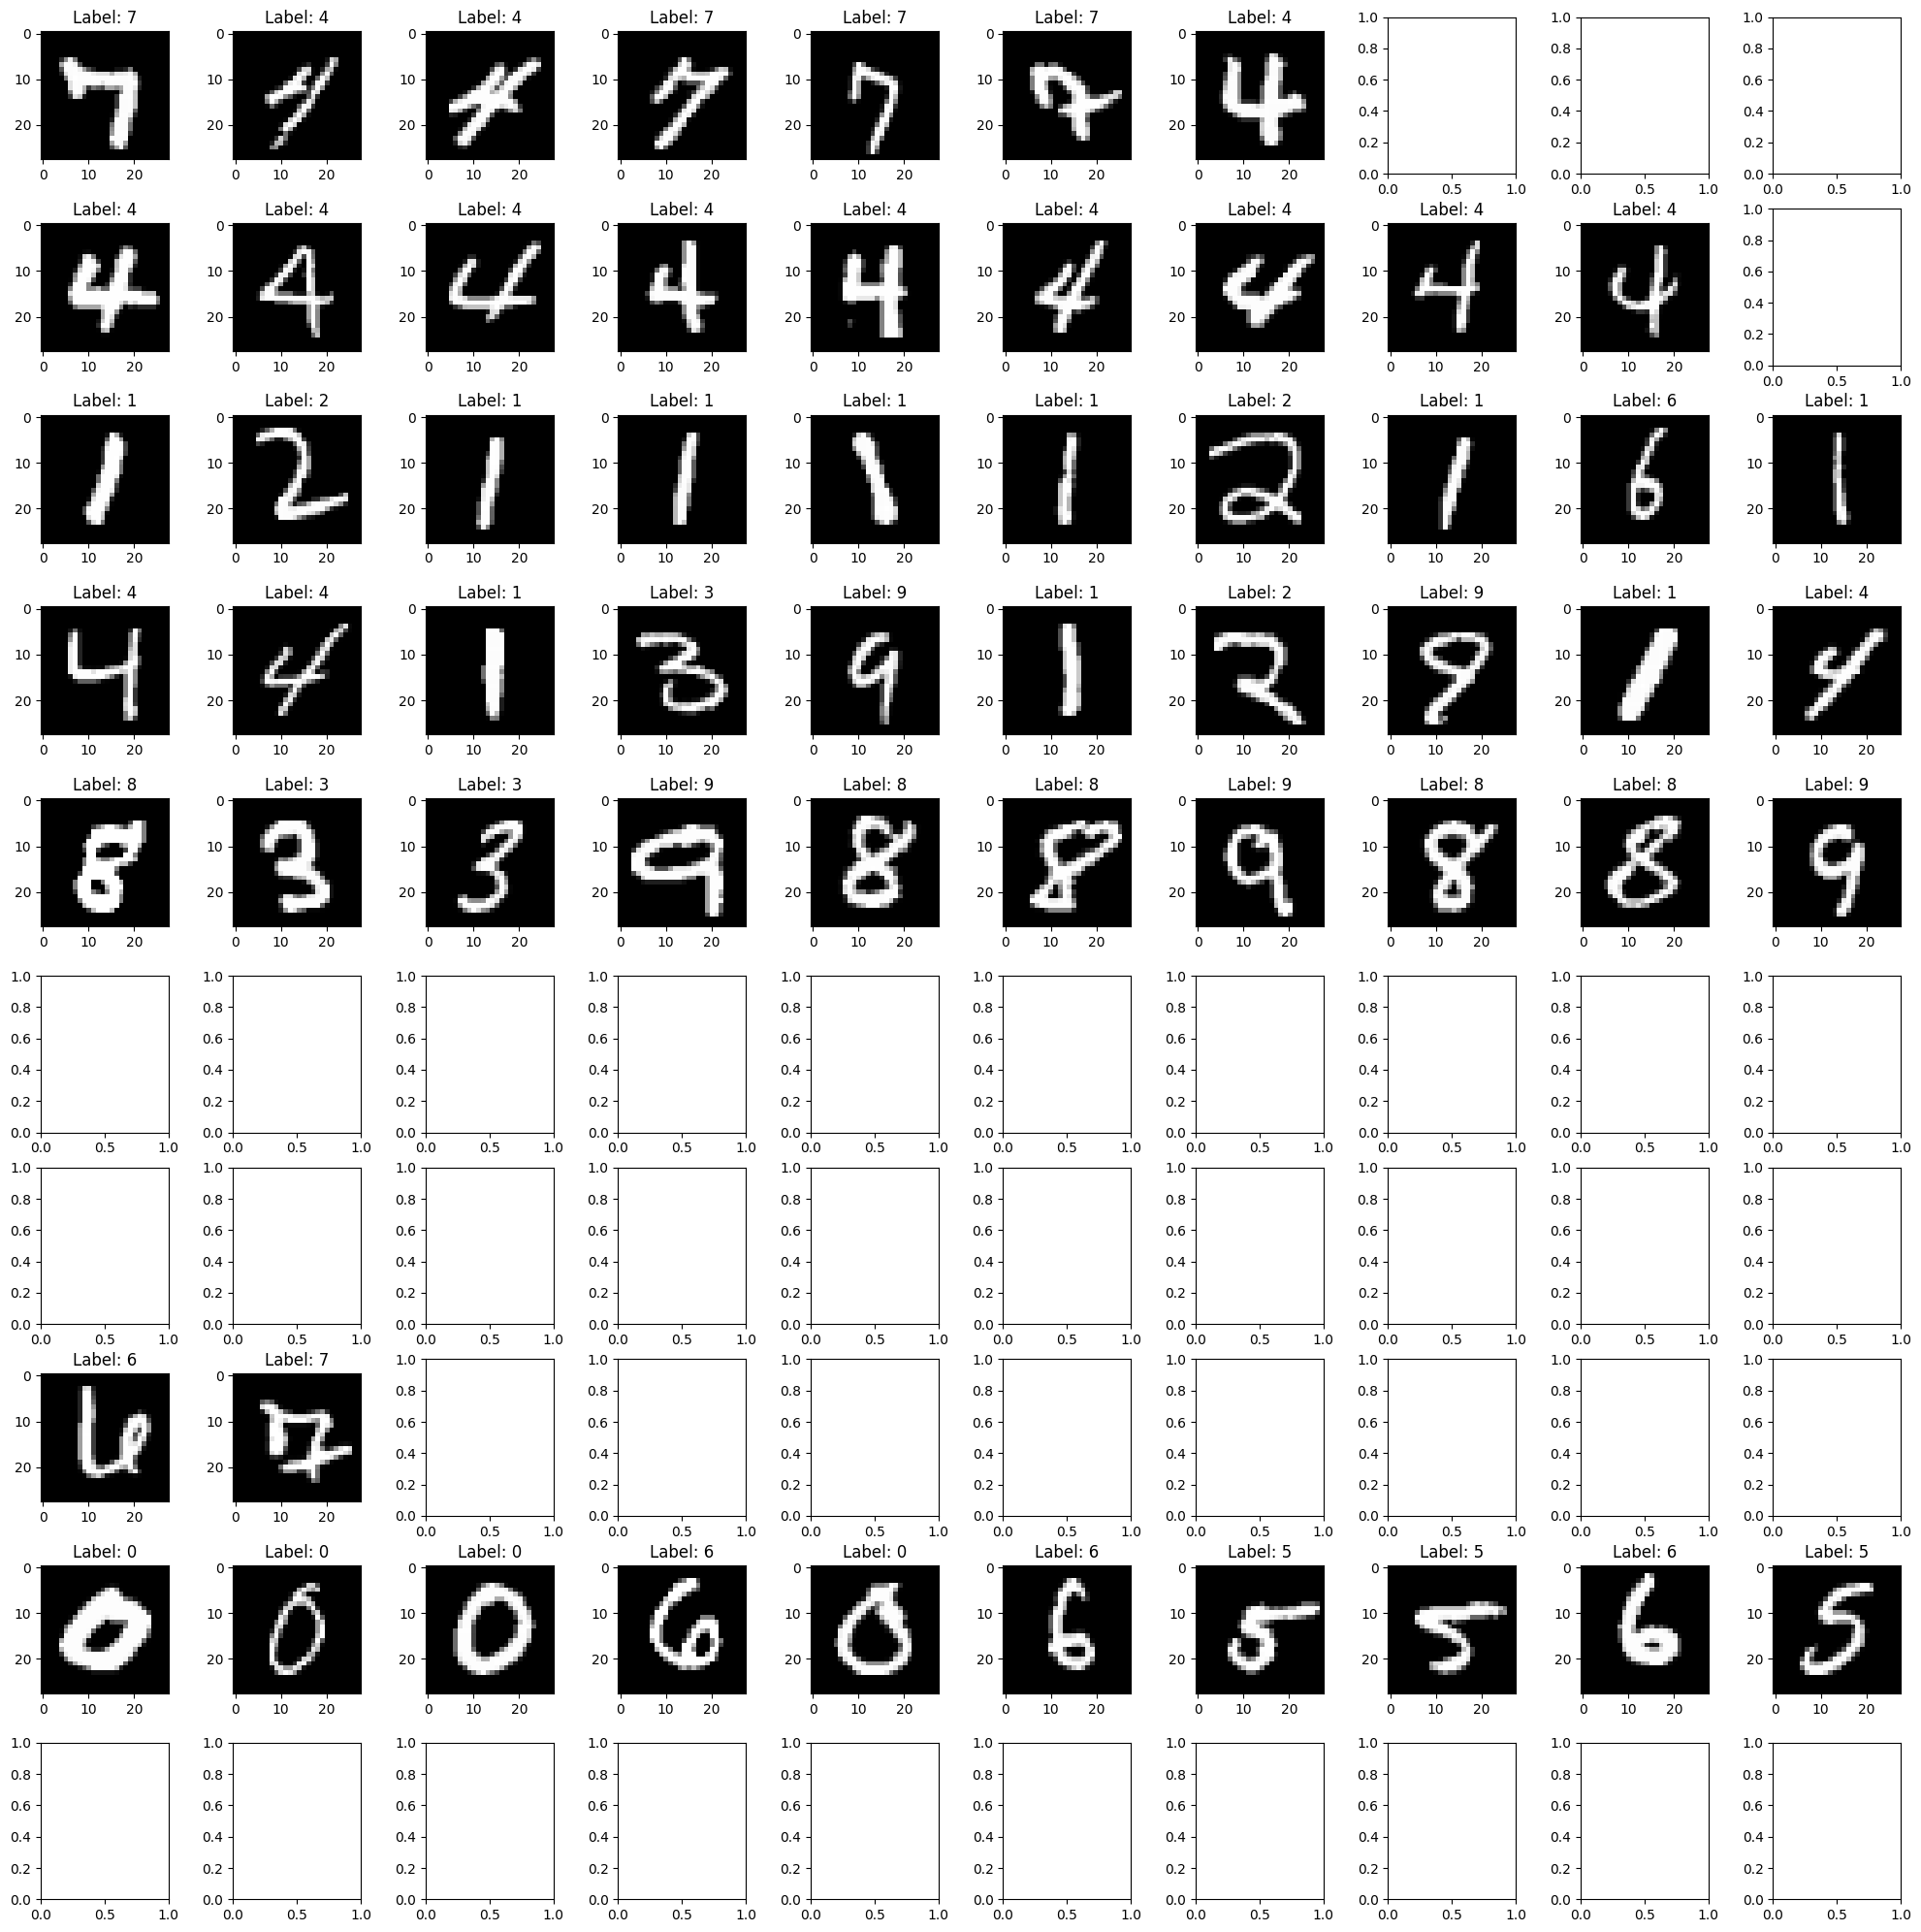

In [30]:
# plot
fig, ax = plt.subplots(nrows=n_sample_plot, ncols=n_sample_plot, figsize=(20, 20)) 
fig.tight_layout(h_pad=0.5)
for i in range(10):
    # select all for class i
    class_indices = get_class_indices(sliced_feature_map, i)
    
    # get random 10
    if class_indices.nelement() < n_sample_plot:
        sampled_class_indices = class_indices
    else:
        sampled_class_indices = class_indices[torch.randint(len(class_indices), (n_sample_plot,))]
    sampled_class_subset = Subset(test_subset, sampled_class_indices)
    
    # get images 
    sampled_class_subset_images = list(map(operator.itemgetter(0), sampled_class_subset))
    
    # get labels 
    sampled_class_subset_labels = list(map(operator.itemgetter(1), sampled_class_subset))    

    for j in range(10):
        if j >= len(sampled_class_subset_images):
            continue
        ax[i, j].imshow(sampled_class_subset_images[j].squeeze().numpy(), cmap='gray')
        ax[i, j].set_title(f'Label: {sampled_class_subset_labels[j]}')

##### Observations & Comments

1. The first obvious observation, on comparing with the plot from the final hidden layer is that there is no one-to-one mapping between a particular class and a neuron. As opposed to the last layer, the penultimate layer has 1024 neurons and we are (at random) choosing 10 of these so there is no reason for them to be one-to-mapped to a particular class. These neurons will have their own patterns they activate for (which may belong to a particular class or many). 

    > For a well-trained and well-generalized network, I would expect that neurons activate for specific patterns and some classes may share these patterns. Another thing is that due to the hierarchial nature of the DNN, these patterns become increasingly abstract which makes it tricky to exactly identify what pattern a neuron may have learnt to detect. 

    > And since the patterns themselves are abstract, it also makes it tricky to tie back a pattern to the original spatial representation of the signal (that is, the image as we see or plot it). 

    > There may also be redundancy in that different neurons might all activate for a specific pattern. There may also be sparsity in that some neurons don't have significant activations for any of the classes. 

    > Looking at the second to last neuron (from the plot above) we see that it activates for a pattern that seems to embody the "roundness" of the image passed. All the images that it has given significant activations (significant enough for it to be highest activation among the other 10 neurons) for are digits which have some "roundness" in their way of writting (0, 6, 5). Similarly, the second neuron from the top (from the plot above) seems to have picked out a  pattern very specific to the digit 4. But the first neuron (from the top) has also picked up on a pattern that is shared by both digits 4 and 7. The fifth neuron (from the top) seems to have picked out a pattern that seems to capture the "double-loop" nature of the digit given that it activates for 8, 3 and 9 both of which have two loops in them (8 has two complete loops, 3 has two half loops and 9 has one loop and a very weak second partial loop). Somewhat similar is the case for the eigth neuron (from the top). 

2. The ideal situation for the penultimate layer would be that there are no neurons which do not significantly activate for even one digit. That is, every neuron that is randomly selected must fire for at least one of the classes (or digits). This would indicate that they have picked out a pattern and are in some way contributing to the overall prediction.  

    > From the plots it is clear that some neurons do not significantly activate for any digit (either they are zero or their activations are weak and hence masked by another neurons) and some neurons activate for the same digits (either they pick out the same pattern or that the patterns they pick out are closely related). 

    > I would think of this as an indication that the network perhaps does not need to be as deep or wide and there is scope for making it smaller and still retaining the performance. 






##### Plotting t-SNE and PCA visualizations from the output of each hidden layer

In [31]:
# get labels from dataset
label_tensor_list = list(map(operator.itemgetter(1), test_subset))
labels = torch.stack(label_tensor_list)

In [32]:
# module list for which the outputs need to be visualized
modules_to_include = [nn.ReLU, nn.LogSoftmax, nn.Flatten]

# filter modules using the module list
modules = dict(model.named_modules())
modules = [(name, module) for name, module in modules.items() if isinstance(module, tuple(modules_to_include))]

# get usable names and layer indexes
module_names = [name.split('.') if '.' in name else (name, -1) for (name, module) in modules]
handles = [register_hook(model, layer_name=name, sub_layer_idx=int(sub_layer_idx) if sub_layer_idx != -1 else -1)
           for (name, sub_layer_idx) in module_names]

In [33]:
# get outputs for each
features = {}
(test_loss, test_accuracy, logits, labels) = model.test_loop(test_subset_dataloader, return_logits=True)

/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


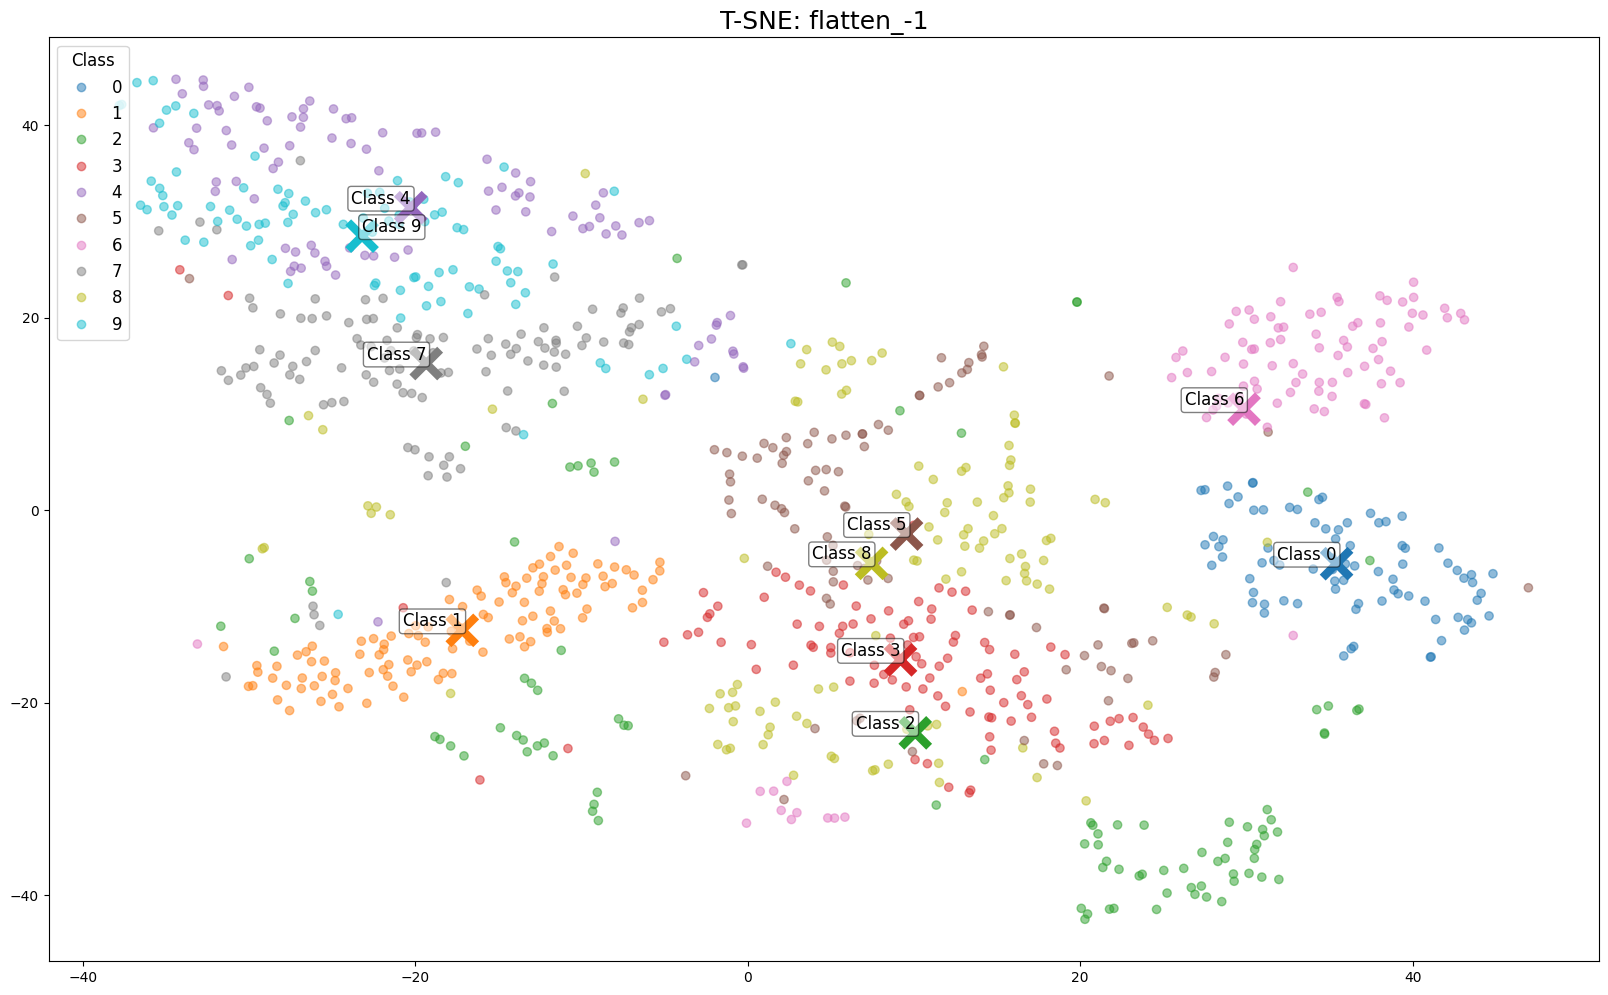

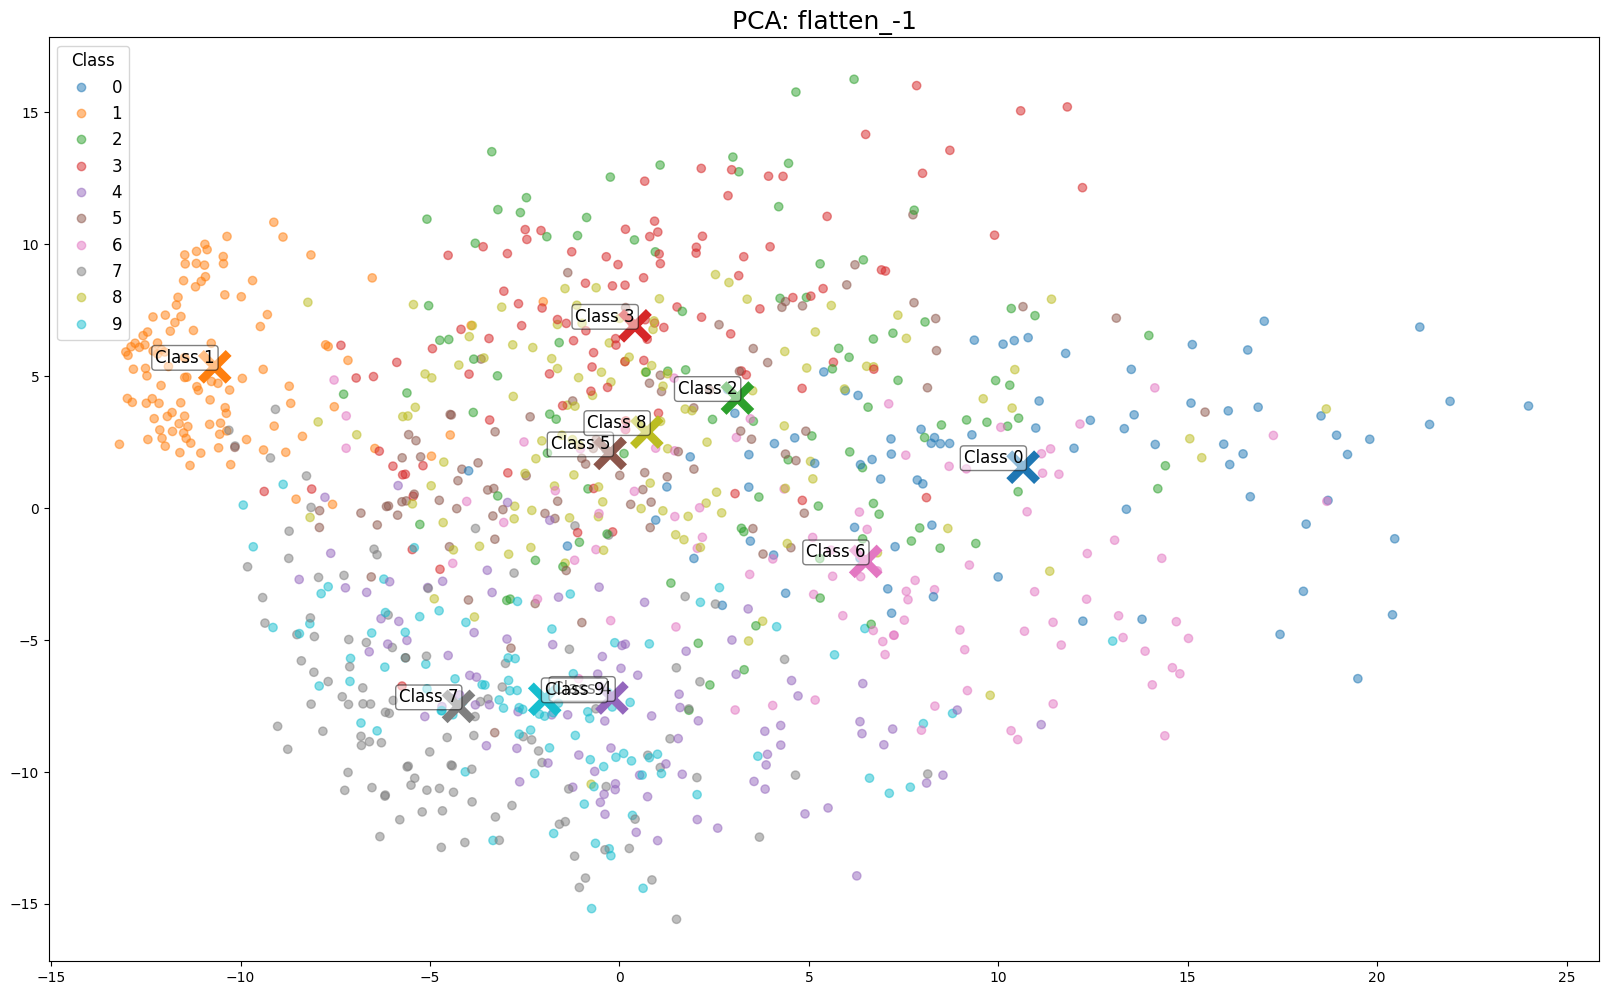

/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


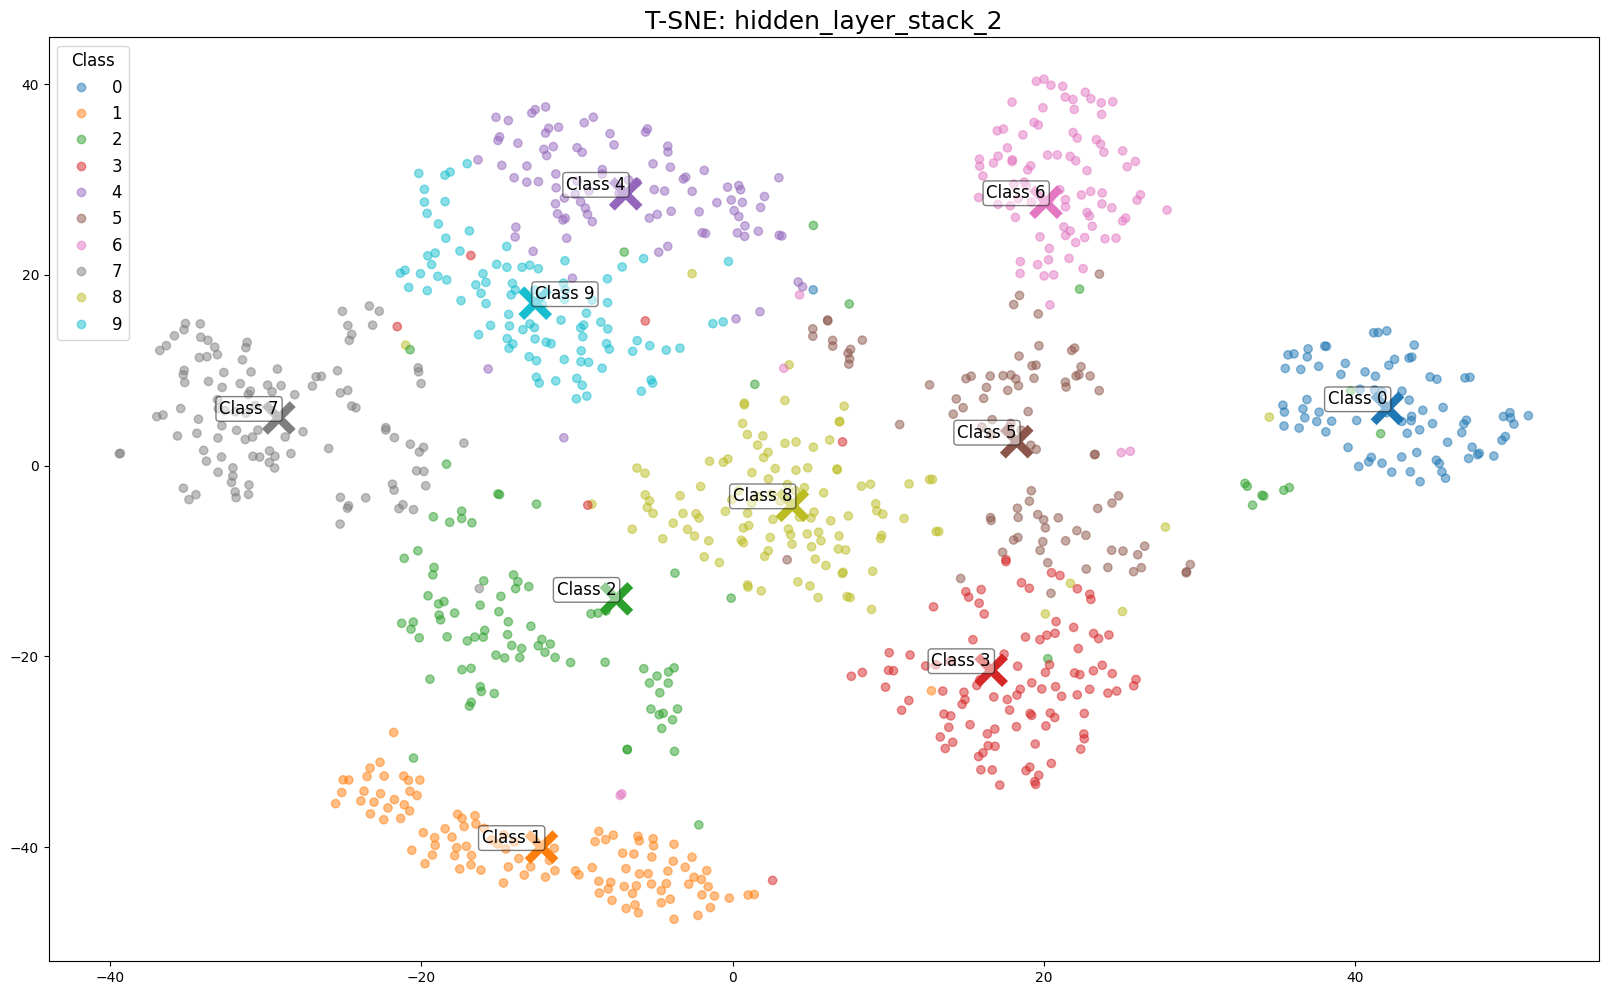

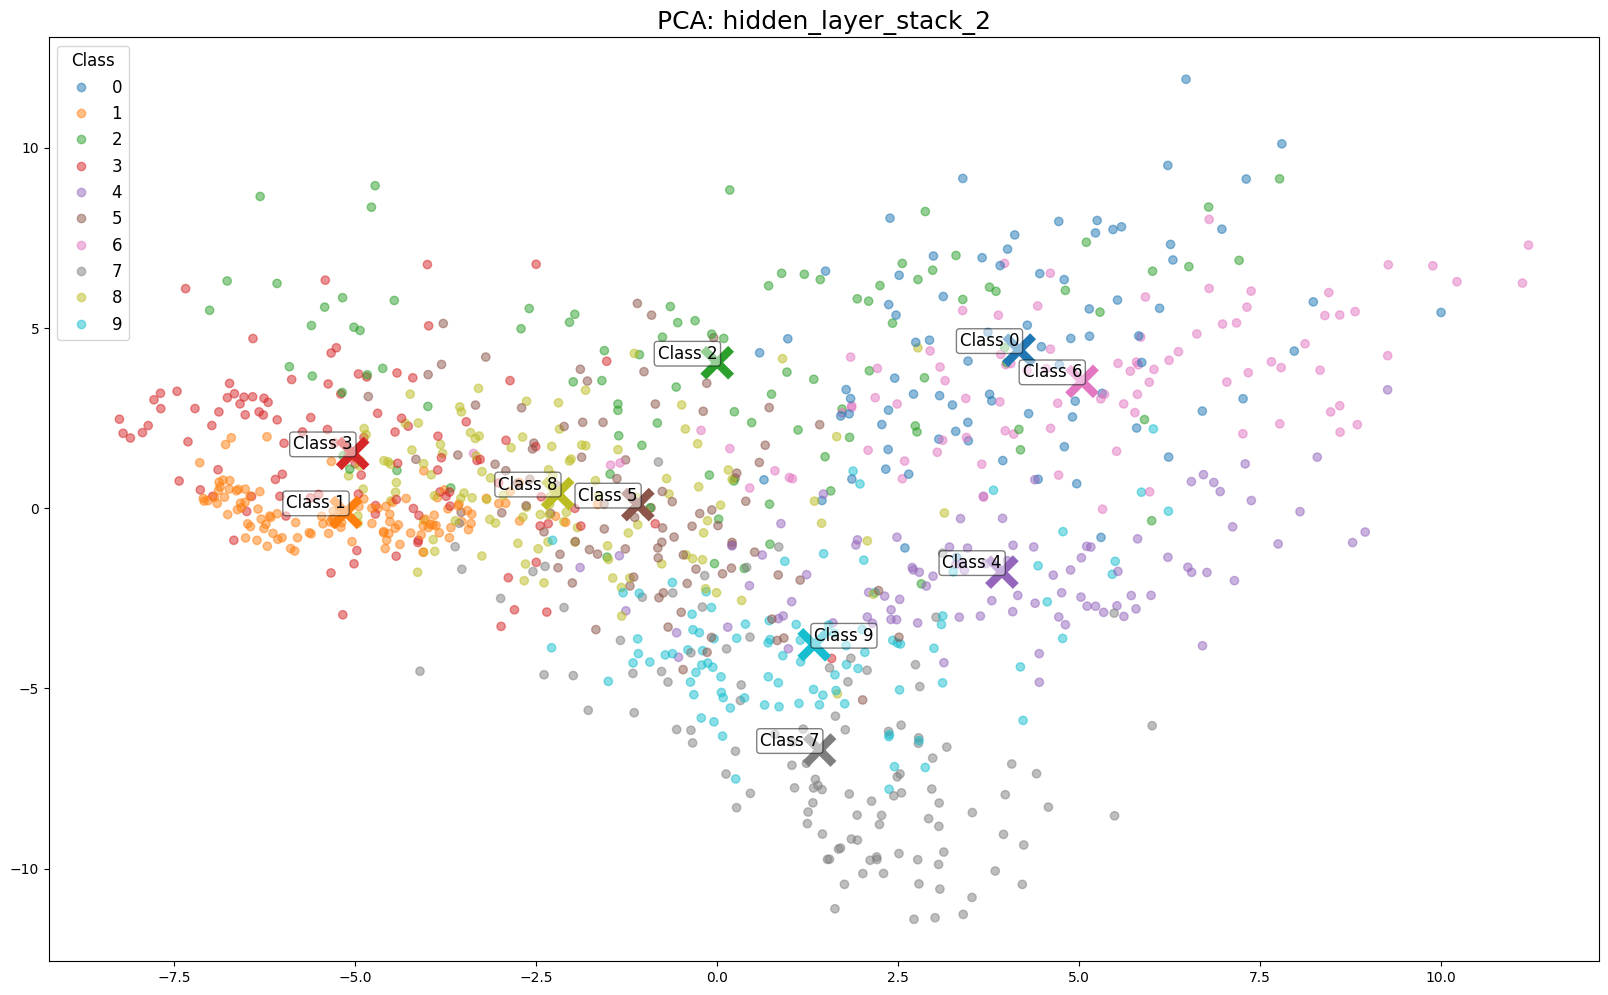

/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


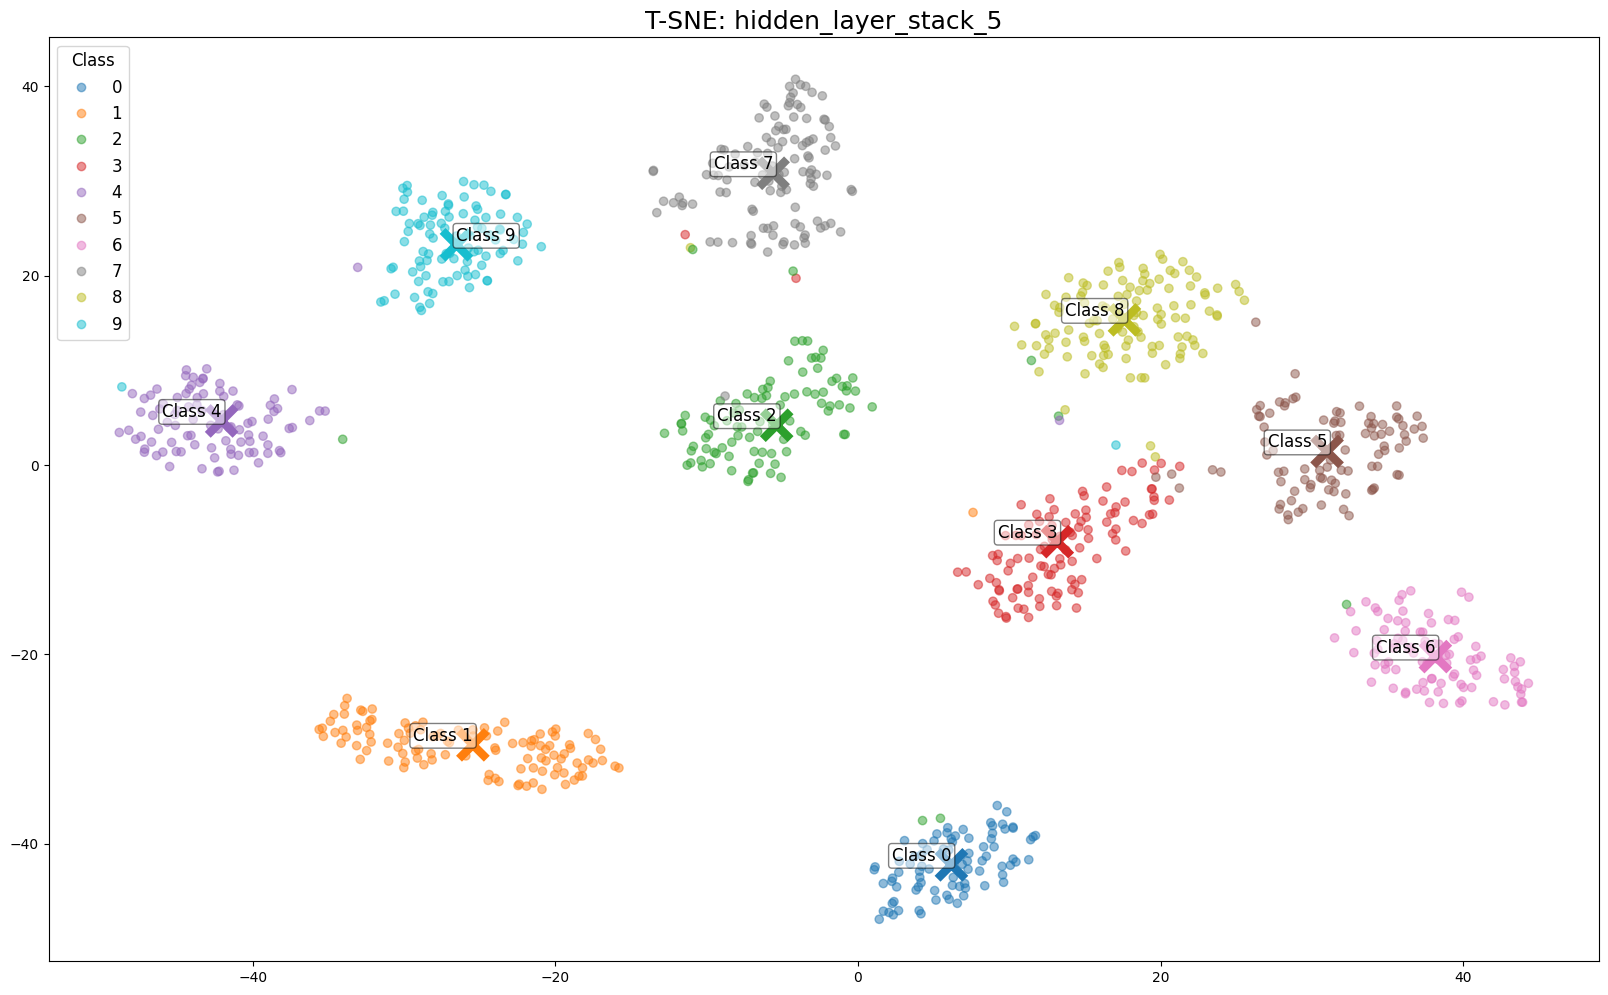

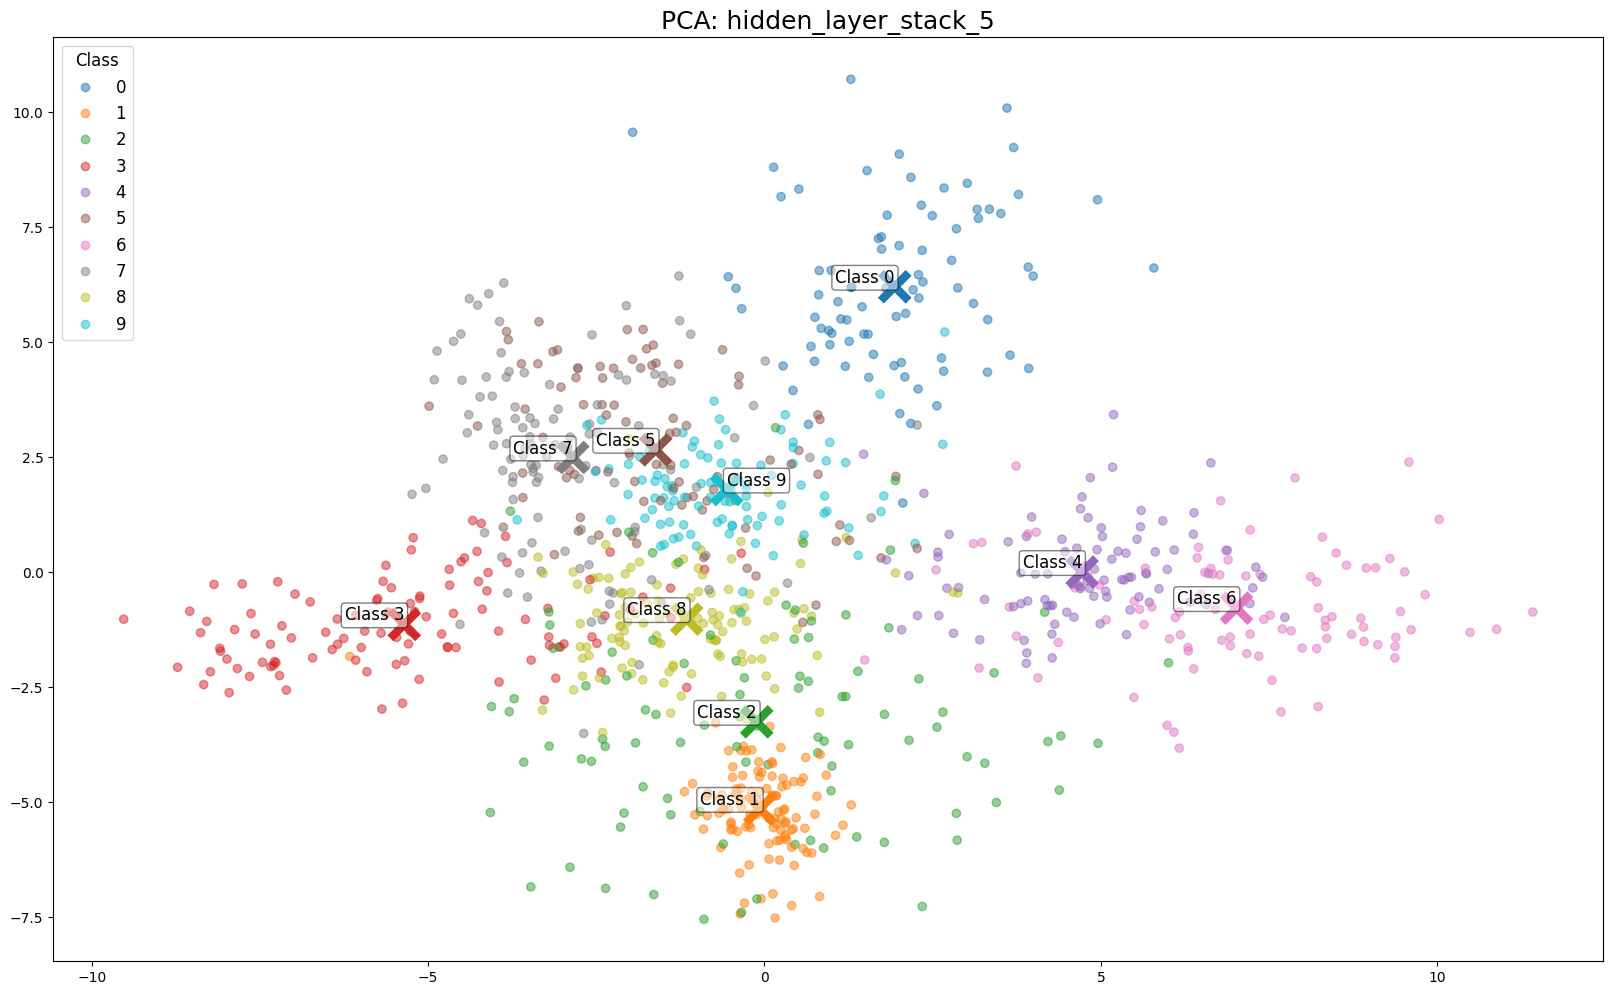

/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


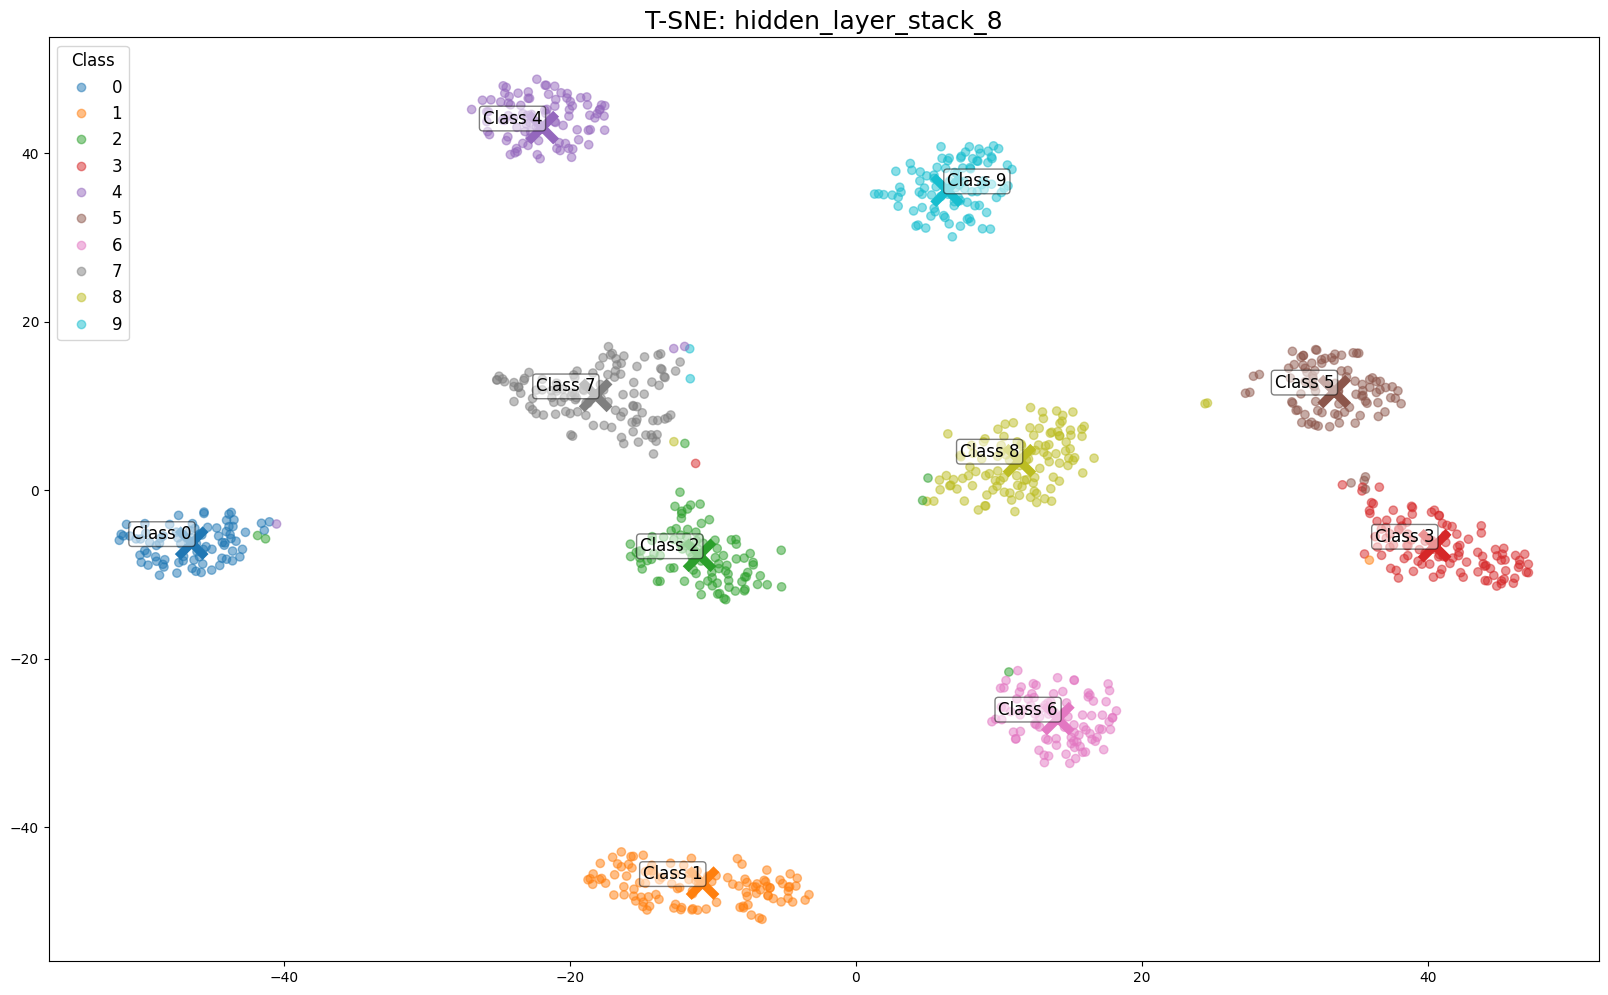

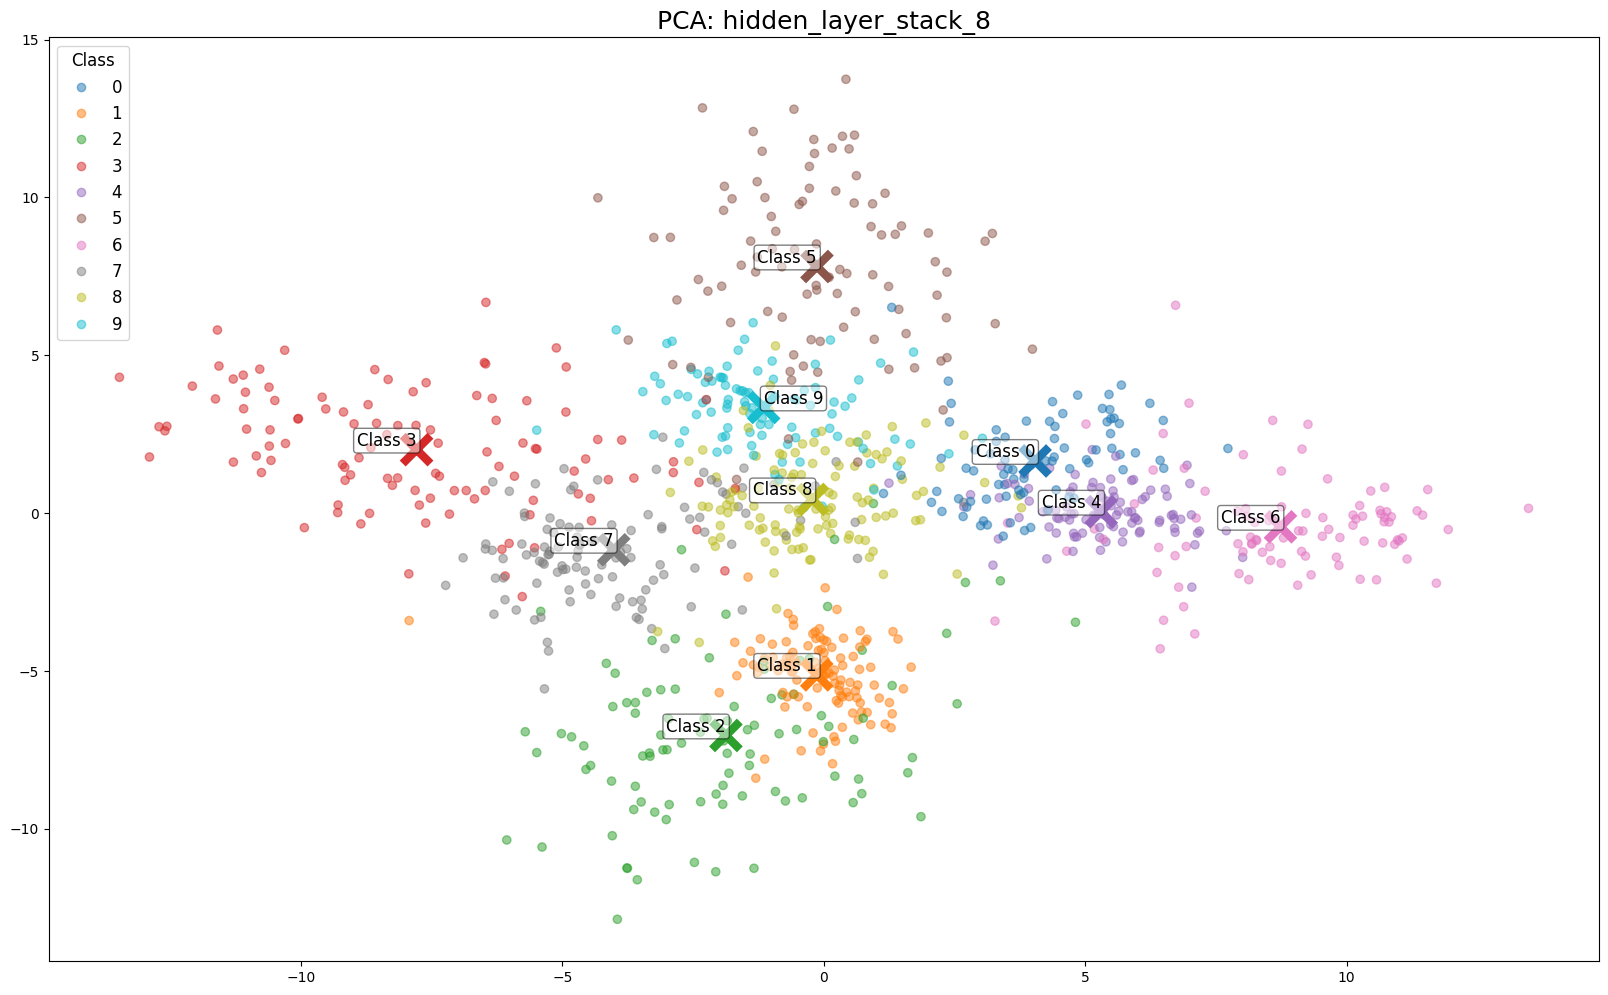

/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


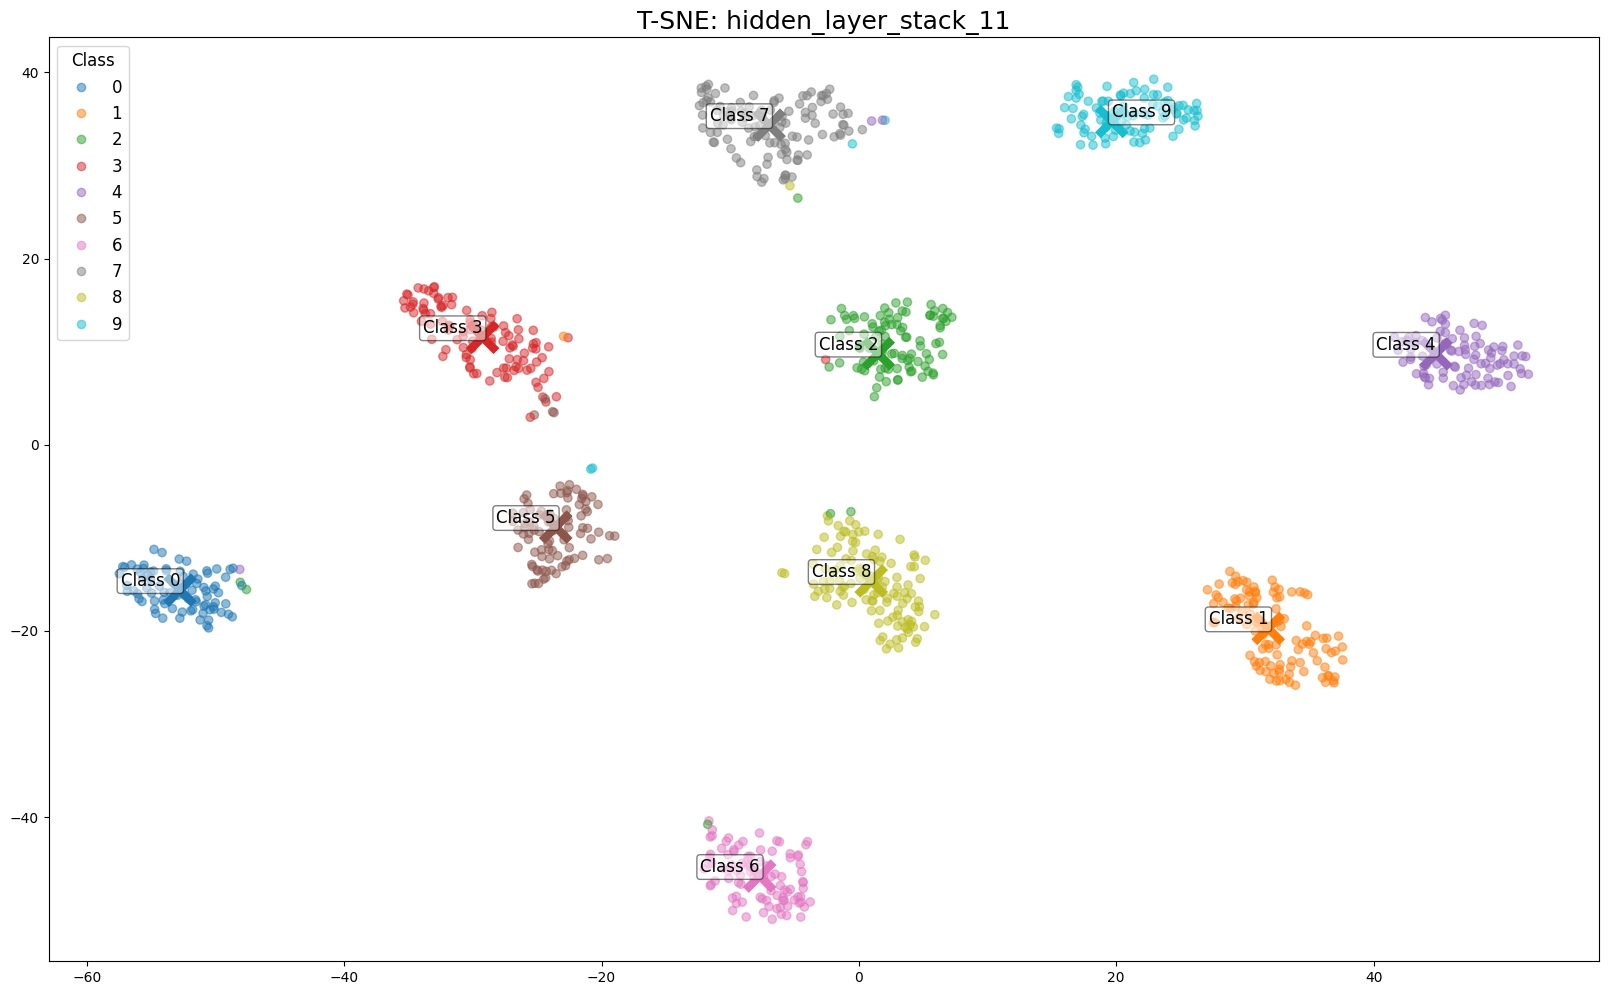

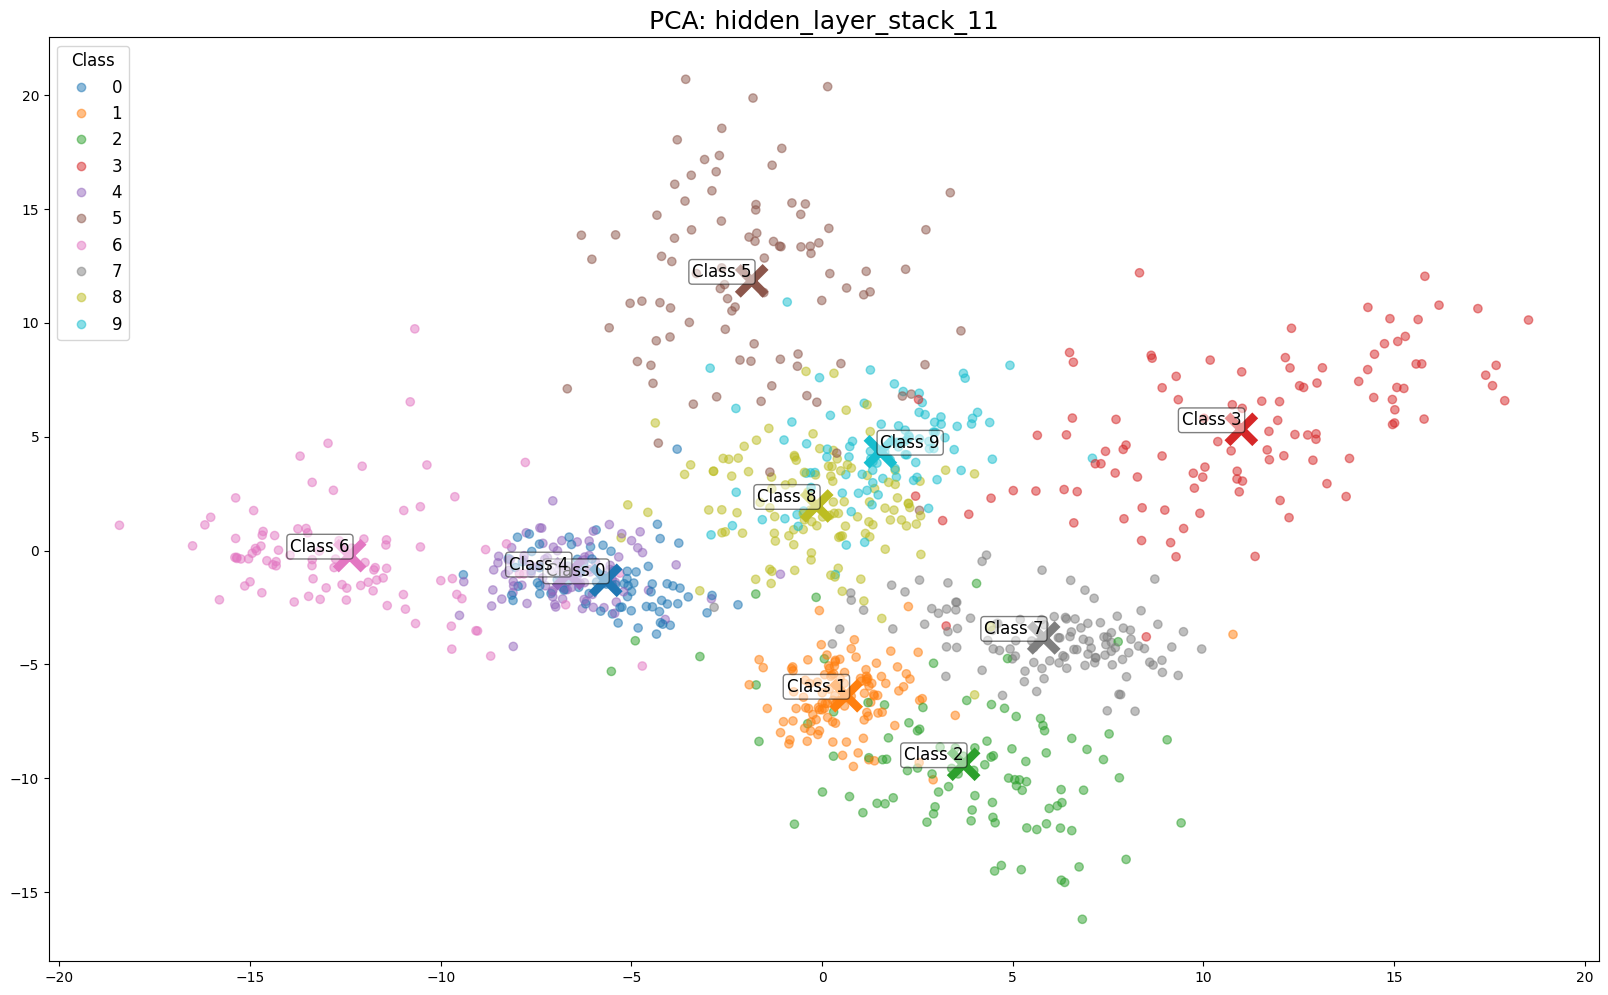

/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bhargavdesai/Desktop/IU/DLS/Assignment 2/dls-assignment-2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


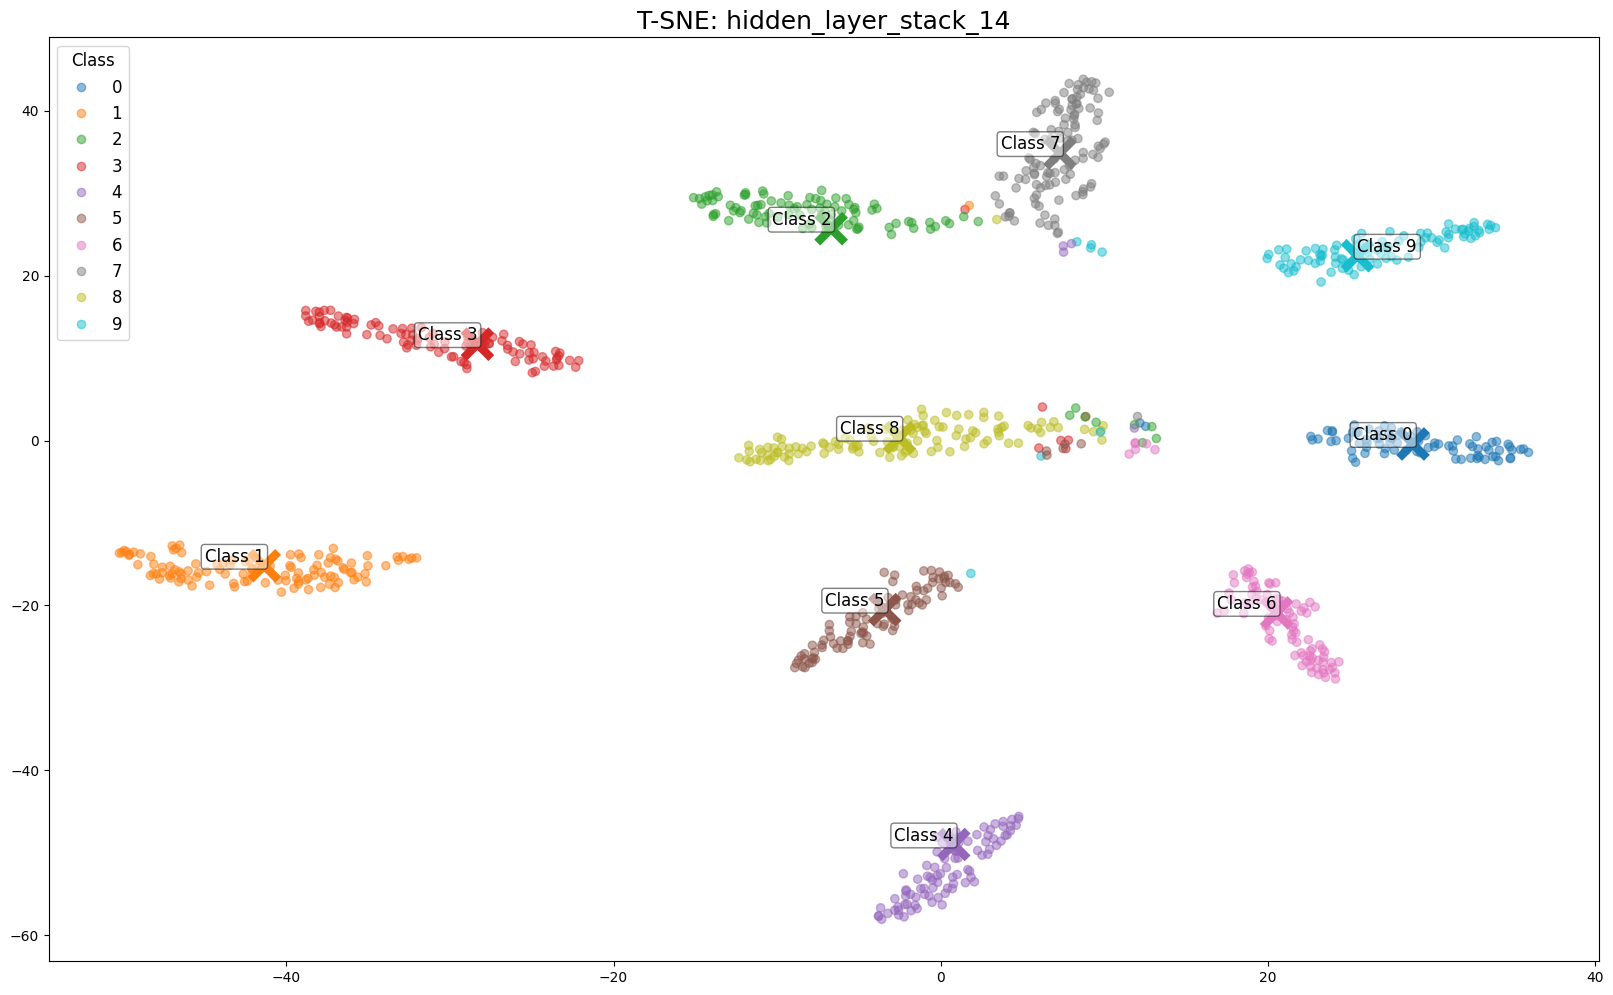

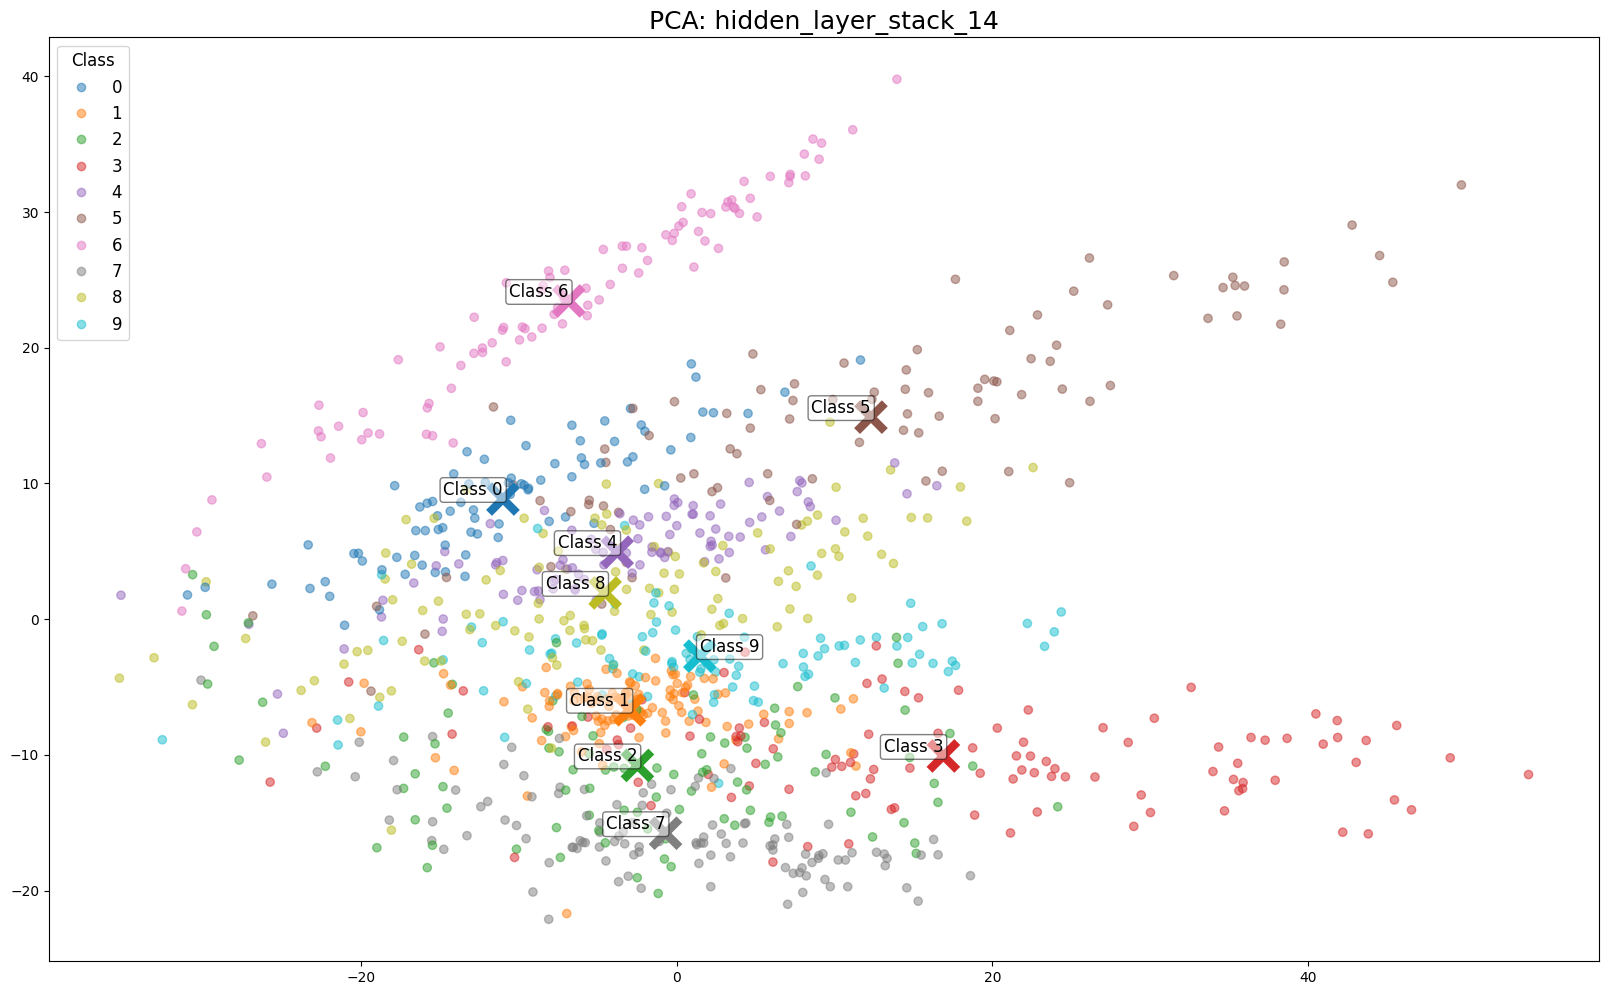

In [34]:
# TSNA, PCA for the modules
for name, feature_map in features.items():
    tsne = TSNE().fit_transform(feature_map.cpu())
    pca = PCA(n_components=2).fit_transform(feature_map.cpu())
    plot_scatter(input_arr=tsne, label_arr=labels, title=f'T-SNE: {name}')
    plot_scatter(input_arr=pca, label_arr=labels, title=f'PCA: {name}')
    plt.show()

##### Observations & Comments

1. The first observation is that the t-SNE technique of dimensionality reduction seems to be much more effective than PCA for this particular problem (with 2 components)
    
    > From the first PCA representation (in `flatten_-1` or the input) to the last representation (in `hidden_layer_stack_14` or the last layer) all the classes are relatively much closer and interspersed than the t-SNE plots. 

    > In the t-SNE plots, with each hidden layer output, the classes progressively get increasingly seperable (as is expected since the deeper we get into the network, the non-linearity allows for better representations of the original input space)

2. The second observation is that while some classes have their own clusters even in the input layer (`flatten_-1`) and can possibly be seperated, towards the end of the network the clusters are much more clear and easily allow for non-ambigious (mostly) boundaries to be drawn between classes. 

    > From the second hidden layer (`hidden_layer_stack_5`) to the second-to-last layer (`hidden_layer_stack_11`), t-SNE shows very clear seperability and perhaps makes a case for the argument that the network can be much smaller and still retain the performance. 

#### Problem 2: Adult Optimization [4 points]

In [35]:
# experiment setup
experiments = {'Experiment 1': {'name': 'Logistic: Normal',
                                'n_layers': 5, 
                                'n_units': 512, 
                                'layer_init': 'normal_', 
                                'activation': 'Sigmoid', 
                                'epochs': 200, 
                                'optimizer': 'SGD', 
                                'learning_rate': 1e-2}, 
               'Experiment 2': {'name': 'Logistic: Xavier',
                                'n_layers': 5, 
                                'n_units': 512, 
                                'layer_init': 'xavier_normal_', 
                                'activation': 'Sigmoid', 
                                'epochs': 200, 
                                'optimizer': 'SGD', 
                                'learning_rate': 1e-2}, 
               'Experiment 3': {'name': 'ReLU: Normal',
                                'n_layers': 5, 
                                'n_units': 512, 
                                'layer_init': 'normal_', 
                                'activation': 'ReLU', 
                                'epochs': 200,
                                'optimizer': 'SGD', 
                                'learning_rate': 1e-2}, 
               'Experiment 4': {'name': 'ReLU: Xavier',
                                'n_layers': 5, 
                                'n_units': 512, 
                                'layer_init': 'xavier_normal_', 
                                'activation': 'ReLU', 
                                'epochs': 200, 
                                'optimizer': 'SGD', 
                                'learning_rate': 1e-2}, 
               'Experiment 5': {'name': 'ReLU: He',
                                'n_layers': 5, 
                                'n_units': 512, 
                                'layer_init': 'kaiming_normal_', 
                                'activation': 'ReLU', 
                                'epochs': 200, 
                                'optimizer': 'SGD', 
                                'learning_rate': 1e-2}, 
               'Experiment 6': {'name': 'Logistic: Normal',
                                'n_layers': 5, 
                                'n_units': 512, 
                                'layer_init': 'normal_', 
                                'activation': 'Sigmoid', 
                                'epochs': 200, 
                                'optimizer': 'Adam', 
                                'learning_rate': 1e-3}, 
               'Experiment 7': {'name': 'Logistic: Xavier',
                                'n_layers': 5, 
                                'n_units': 512, 
                                'layer_init': 'xavier_normal_', 
                                'activation': 'Sigmoid', 
                                'epochs': 200, 
                                'optimizer': 'Adam', 
                                'learning_rate': 1e-3}, 
               'Experiment 8': {'name': 'ReLU: Normal',
                                'n_layers': 5, 
                                'n_units': 512, 
                                'layer_init': 'normal_', 
                                'activation': 'ReLU', 
                                'epochs': 200,
                                'optimizer': 'Adam', 
                                'learning_rate': 1e-3}, 
               'Experiment 9': {'name': 'ReLU: Xavier',
                                'n_layers': 5, 
                                'n_units': 512, 
                                'layer_init': 'xavier_normal_', 
                                'activation': 'ReLU', 
                                'epochs': 200, 
                                'optimizer': 'Adam', 
                                'learning_rate': 1e-3}, 
               'Experiment 10': {'name': 'ReLU: He',
                                 'n_layers': 5, 
                                 'n_units': 512, 
                                 'layer_init': 'kaiming_normal_', 
                                 'activation': 'ReLU', 
                                 'epochs': 200, 
                                 'optimizer': 'Adam', 
                                 'learning_rate': 1e-3}, 
               
              }

In [36]:
# run experiment
metrics = {}
for experiment_num, setup in tqdm(experiments.items()):
    
    # log setup
    print(experiment_num, setup['name'])
    
    # initialize model
    model = NeuralNetwork(n_layers=setup['n_layers'], 
                          n_units=setup['n_units'],
                          layer_init=setup['layer_init'],
                          activation=setup['activation']).to(device)
    
    # optimizer
    optimizer = getattr(torch.optim, setup['optimizer'])(model.parameters(), 
                                                         lr=setup['learning_rate'])
    
    # train model
    train_metrics, test_metrics = model.train_model(epochs=setup['epochs'], 
                                                    train_dataloader=train_dataloader, 
                                                    test_dataloader=test_dataloader,
                                                    optimizer=optimizer, 
                                                    return_metrics=True)
    metrics[experiment_num] = test_metrics['Accuracy']

  0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1 Logistic: Normal


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment 2 Logistic: Xavier


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment 3 ReLU: Normal


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment 4 ReLU: Xavier


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment 5 ReLU: He


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment 6 Logistic: Normal


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment 7 Logistic: Xavier


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment 8 ReLU: Normal


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment 9 ReLU: Xavier


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment 10 ReLU: He


  0%|          | 0/200 [00:00<?, ?it/s]

In [41]:
# collect SGD metrics
sgd_metrics = {setup['name']: metrics[experiment_num] 
               for experiment_num, setup in experiments.items()
               if setup['optimizer'] == 'SGD'}


# collect Adam metrics
adam_metrics = {setup['name']: metrics[experiment_num] 
                for experiment_num, setup in experiments.items()
                if setup['optimizer'] == 'Adam'}

In [42]:
sgd_test_accuracies = np.array(list(sgd_metrics.values()))
adam_test_accuracies = np.array(list(adam_metrics.values()))

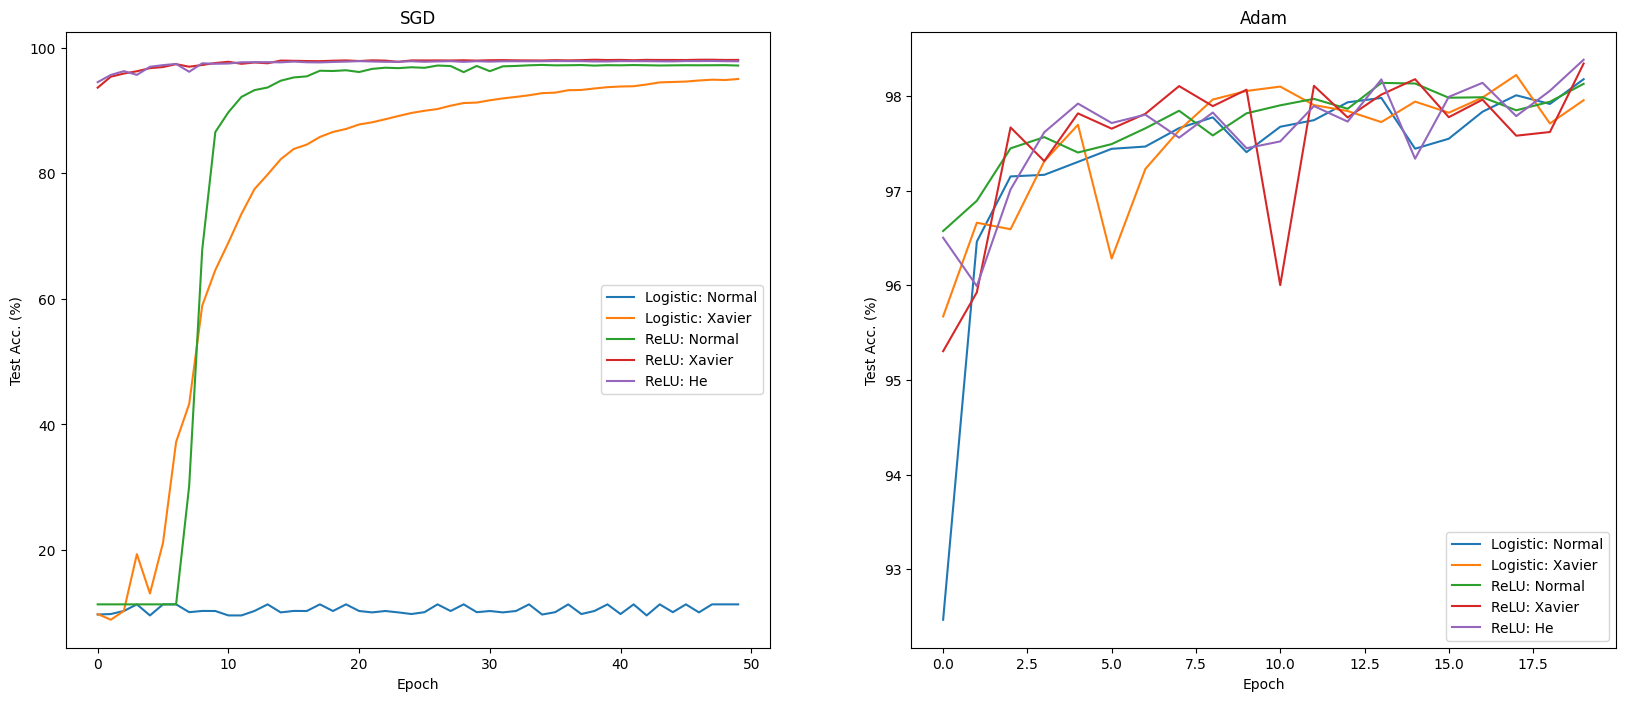

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# sgd 50
line = ax[0].plot(sgd_test_accuracies.T[:50, :] * 100)
ax[0].set_title('SGD')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Test Acc. (%)')
ax[0].legend(iter(line), sgd_metrics.keys())


# adam 20
line = ax[1].plot(adam_test_accuracies.T[:20, :] * 100)
ax[1].set_title('Adam')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Acc. (%)')
ax[1].legend(iter(line), adam_metrics.keys())

plt.show()

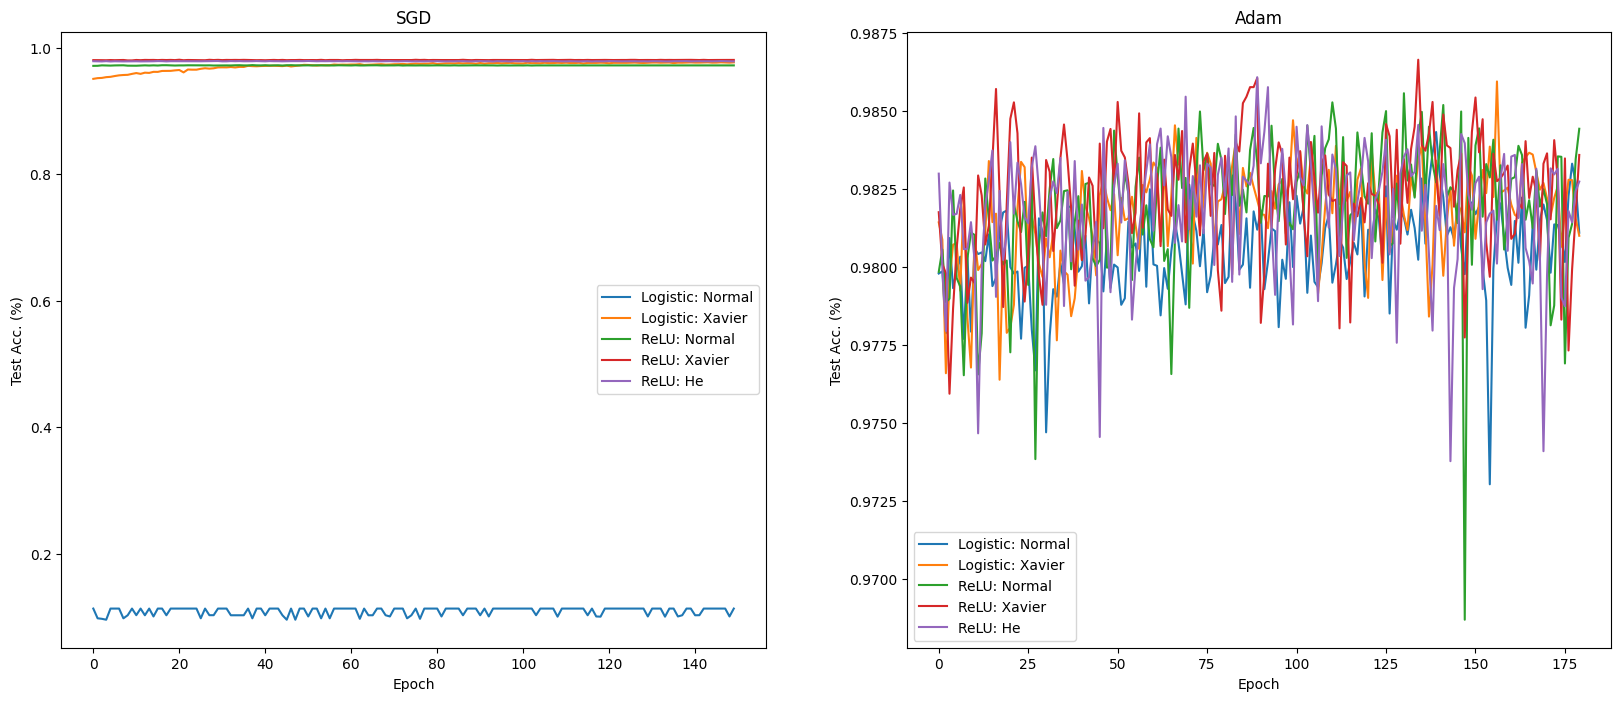

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# sgd 200
line = ax[0].plot(sgd_test_accuracies.T[50:, :])
ax[0].set_title('SGD')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Test Acc. (%)')
ax[0].legend(iter(line), sgd_metrics.keys())

# adam 200
line = ax[1].plot(adam_test_accuracies.T[20:, :])
ax[1].set_title('Adam')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Acc. (%)')
ax[1].legend(iter(line), adam_metrics.keys())

plt.show()

#### Problem 3: Dropout [3 points]

In [45]:
# experiment setup
experiments = {'Experiment 1': {'name': 'Logistic: Xavier (No Dropout)',
                                'n_layers': 5, 
                                'n_units': 1024, 
                                'layer_init': 'xavier_normal_', 
                                'activation': 'Sigmoid', 
                                'dropout': [0.0] * 5,
                                'epochs': 500, 
                                'optimizer': 'Adam', 
                                'learning_rate': 1e-3}, 
               'Experiment 2': {'name': 'Logistic: Xavier (Dropout)',
                                'n_layers': 5, 
                                'n_units': 1024, 
                                'layer_init': 'xavier_normal_', 
                                'activation': 'Sigmoid', 
                                'dropout': [0.2] + [0.5] * 4,
                                'epochs': 500, 
                                'optimizer': 'Adam', 
                                'learning_rate': 1e-3}, 
               'Experiment 3': {'name': 'ReLU: He (No Dropout)',
                                'n_layers': 5, 
                                'n_units': 1024, 
                                'layer_init': 'kaiming_normal_', 
                                'activation': 'ReLU', 
                                'dropout': [0.0]* 5,
                                'epochs': 500,
                                'optimizer': 'Adam', 
                                'learning_rate': 1e-3}, 
               'Experiment 4': {'name': 'ReLU: He (Dropout)',
                                'n_layers': 5, 
                                'n_units': 1024, 
                                'layer_init': 'kaiming_normal_', 
                                'activation': 'ReLU', 
                                'dropout': [0.2] + [0.5] * 4,
                                'epochs': 500, 
                                'optimizer': 'Adam', 
                                'learning_rate': 1e-3}
              }

In [46]:
# run experiment
metrics = {}
for experiment_num, setup in tqdm(experiments.items()):
    
    # log setup
    print(experiment_num, setup['name'])
    
    # initialize model
    model = NeuralNetwork(n_layers=setup['n_layers'], 
                          n_units=setup['n_units'],
                          layer_init=setup['layer_init'],
                          activation=setup['activation'], 
                          dropout=setup['dropout']).to(device)
    
    # optimizer
    optimizer = getattr(torch.optim, setup['optimizer'])(model.parameters(), 
                                                         lr=setup['learning_rate'])
    
    # train model
    train_metrics, test_metrics = model.train_model(epochs=setup['epochs'], 
                                                    train_dataloader=train_dataloader, 
                                                    test_dataloader=test_dataloader,
                                                    optimizer=optimizer, 
                                                    return_metrics=True)
    
    # collect metrics
    metrics[experiment_num] = (train_metrics['Loss'], test_metrics['Loss'])

  0%|          | 0/4 [00:00<?, ?it/s]

Experiment 1 Logistic: Xavier (No Dropout)


  0%|          | 0/500 [00:00<?, ?it/s]

Experiment 2 Logistic: Xavier (Dropout)


  0%|          | 0/500 [00:00<?, ?it/s]

Experiment 3 ReLU: He (No Dropout)


  0%|          | 0/500 [00:00<?, ?it/s]

Experiment 4 ReLU: He (Dropout)


  0%|          | 0/500 [00:00<?, ?it/s]

In [88]:
# collect train metrics
logistic_metrics = {setup['name']: metrics[experiment_num] 
               for experiment_num, setup in experiments.items()
               if setup['activation'] == 'Sigmoid'}


# collect test metrics
relu_metrics = {setup['name']: metrics[experiment_num] 
                for experiment_num, setup in experiments.items()
                if setup['activation'] == 'ReLU'}

In [90]:
logistic_train_loss_nd = {'No Dropout: Train Loss': logistic_metrics['Logistic: Xavier (No Dropout)'][0]}
logistic_test_loss_nd = {'No Dropout: Test Loss': logistic_metrics['Logistic: Xavier (No Dropout)'][1]}

logistic_train_loss_d = {'Dropout: Train Loss': logistic_metrics['Logistic: Xavier (Dropout)'][0]}
logistic_test_loss_d = {'Dropout: Test Loss': logistic_metrics['Logistic: Xavier (Dropout)'][1]}


relu_train_loss_nd = {'No Dropout: Train Loss': relu_metrics['ReLU: He (No Dropout)'][0]}
relu_test_loss_nd = {'No Dropout: Test Loss': relu_metrics['ReLU: He (No Dropout)'][1]}

relu_train_loss_d = {'Dropout: Train Loss': relu_metrics['ReLU: He (Dropout)'][0]}
relu_test_loss_d = {'Dropout: Test Loss': relu_metrics['ReLU: He (Dropout)'][1]}

In [93]:
plot_1 = dict(chain.from_iterable(d.items() for d in (logistic_train_loss_nd, 
                                                      logistic_test_loss_nd, 
                                                      logistic_train_loss_d, 
                                                      logistic_test_loss_d)))

plot_2 = dict(chain.from_iterable(d.items() for d in (relu_train_loss_nd, 
                                                      relu_test_loss_nd, 
                                                      relu_train_loss_d, 
                                                      relu_test_loss_d)))

In [82]:
plot_1_values = np.array(list(plot_1.values()))
plot_2_values = np.array(list(plot_2.values()))

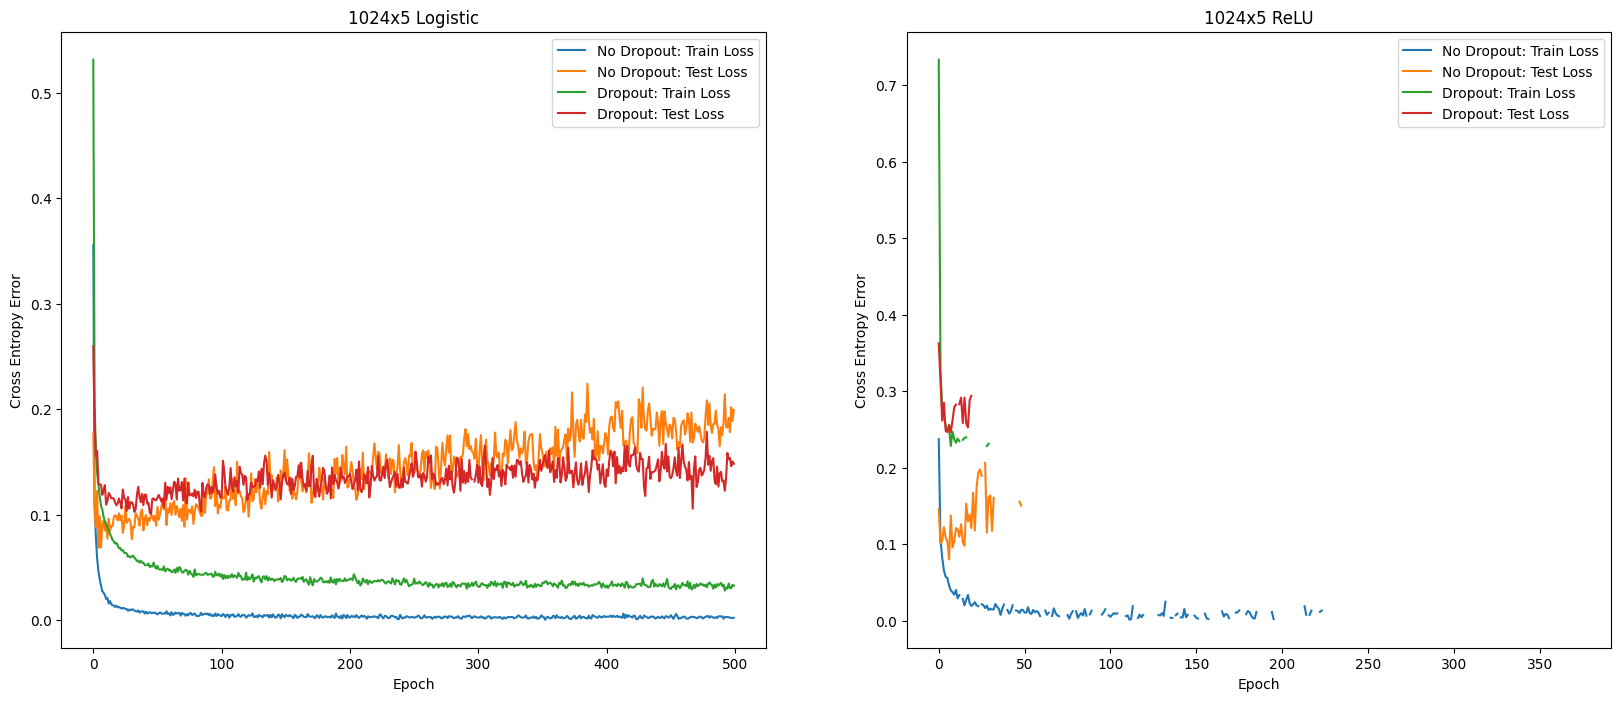

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# sgd 50
line = ax[0].plot(plot_1_values.T)
ax[0].set_title('1024x5 Logistic')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Cross Entropy Error')
ax[0].legend(iter(line), plot_1.keys())

# adam 20
line = ax[1].plot(plot_2_values.T)
ax[1].set_title('1024x5 ReLU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Cross Entropy Error')
ax[1].legend(iter(line), plot_2.keys())


plt.show()